# **04 - Feature Engineering**

## Objectives

* Write your notebook objective here, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* Write here which data or information you need to run the notebook 

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/Users/pieterkdevilliers/Desktop/Development/Code Institute/pp5-heritage-housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

# Load Cleaned Data

Train Set

In [3]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0    1828.0       0.0           3.0           Av        48.0           4.0   
1     894.0       0.0           2.0           No         0.0           1.0   
2     964.0       0.0           2.0           No       713.0           5.0   

   BsmtUnfSF  GarageArea  GarageFinish  GarageYrBlt  ...  LotArea LotFrontage  \
0     1774.0       774.0           1.0       2007.0  ...  11694.0        90.0   
1      894.0       308.0           2.0       1962.0  ...   6600.0        60.0   
2      163.0       432.0           1.0       1921.0  ...  13360.0        80.0   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0       452.0        108.0          5.0          9.0       1822.0       2007   
1         0.0          0.0          5.0          5.0        894.0       1962   
2         0.0          0.0          7.0          5.0        876.0       1921   

   YearRemodAdd  SalePrice  
0          2007   314813.0  
1          1962   109500.0  
2          2006   163500.0  

[3 rows x 22 columns]

Test Set

In [4]:
test_set_path = 'outputs/datasets/cleaned/TestSetCleaned.csv'
TestSet = pd.read_csv(test_set_path)
TestSet.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0    2515.0       0.0           4.0           No      1219.0           3.0   
1     958.0     620.0           3.0           No       403.0           4.0   
2     979.0     224.0           3.0           No       185.0           2.0   

   BsmtUnfSF  GarageArea  GarageFinish  GarageYrBlt  ...  LotArea LotFrontage  \
0      816.0       484.0           2.0       1975.0  ...  32668.0        70.0   
1      238.0       240.0           1.0       1941.0  ...   9490.0        79.0   
2      524.0       352.0           1.0       1950.0  ...   7015.0        70.0   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0         0.0          0.0          3.0          6.0       2035.0       1957   
1         0.0          0.0          7.0          6.0        806.0       1941   
2       161.0          0.0          4.0          5.0        709.0       1950   

   YearRemodAdd  SalePrice  
0          1975   200624.0  
1          1950   133000.0  
2          1950   110000.0  

[3 rows x 22 columns]

---

# Data Exploration

In feature engineering, you are interested to evaluate which potential transformation you could do in your variables

In [5]:
from pandas_profiling import ProfileReport
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

/var/folders/vg/xr2t0ncx7c98wfntvs622gs80000gn/T/ipykernel_53096/4017232469.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

# Feature Engineering

## Custom function

In [11]:
import scipy.stats as stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


---

## Dealing with Feature Engineering

List the transformers you will use
* Categorical Encoding
* Numerical Transformation
* Smart Correlation Selection

### Categorical Encoding - Ordinal: replaces categories with ordinal numbers 

* Step 1: Select variable(s)

In [7]:
TrainSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      1168 non-null   float64
 1   2ndFlrSF      1168 non-null   float64
 2   BedroomAbvGr  1168 non-null   float64
 3   BsmtExposure  1168 non-null   object 
 4   BsmtFinSF1    1168 non-null   float64
 5   BsmtFinType1  1168 non-null   float64
 6   BsmtUnfSF     1168 non-null   float64
 7   GarageArea    1168 non-null   float64
 8   GarageFinish  1168 non-null   float64
 9   GarageYrBlt   1168 non-null   float64
 10  GrLivArea     1168 non-null   float64
 11  KitchenQual   1168 non-null   object 
 12  LotArea       1168 non-null   float64
 13  LotFrontage   1168 non-null   float64
 14  MasVnrArea    1168 non-null   float64
 15  OpenPorchSF   1168 non-null   float64
 16  OverallCond   1168 non-null   float64
 17  OverallQual   1168 non-null   float64
 18  TotalBsmtSF   1168 non-null 

In [15]:
variables_engineering= ['BsmtExposure', 'KitchenQual']

variables_engineering

['BsmtExposure', 'KitchenQual']

* Step 2: Create a separate DataFrame, with your variable(s)

In [16]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(10)

BsmtExposure KitchenQual
0           Av          Gd
1           No          TA
2           No          TA
3           No          Gd
4           No          Gd
5           No          Gd
6           No          TA
7           No          Gd
8           Gd          TA
9           No          TA

* Step 3: Create engineered variables(s) by applying the transformation(s), assess engineered variables distribution and select the most suitable method for each variable.

* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_ordinal_encoder'] 



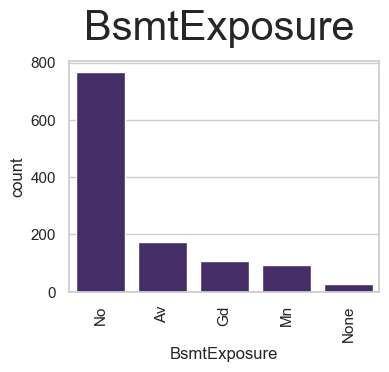

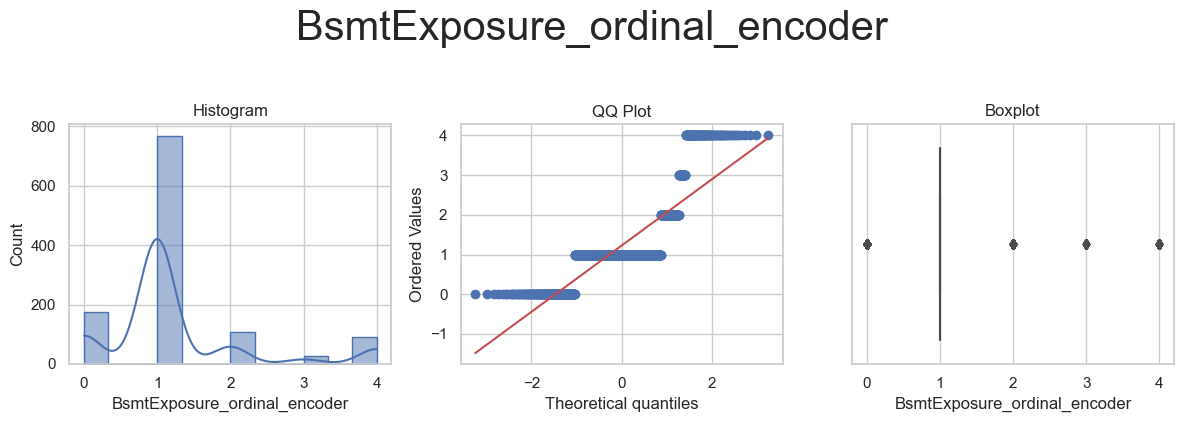



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 



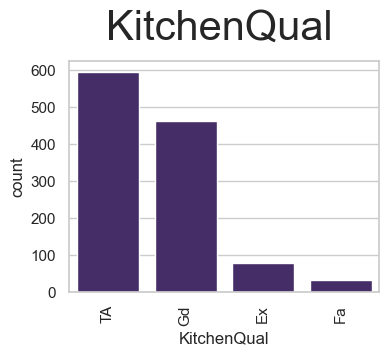

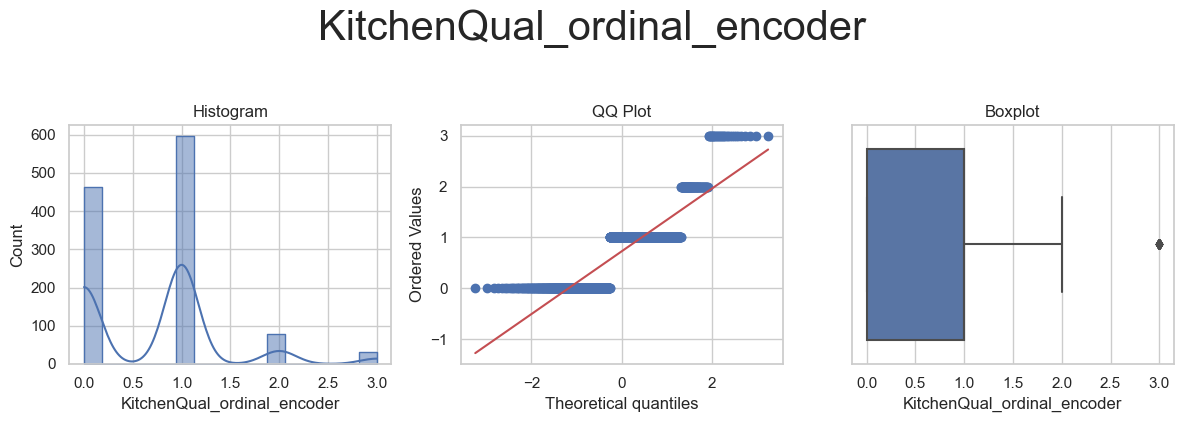

In [17]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='ordinal_encoder')

* For each variable, write your conclusion on how the transformation(s) look(s) to be effective.
  * For all variables, the transformation is effective, since it converted categories to numbers.



* Step 4 - Apply the selected transformation to the Train and Test set

In [18]:
# the steps are: 
# 1 - create a transformer
# 2 - fit_transform into TrainSet
# 3 - transform into TestSet 
encoder = OrdinalEncoder(encoding_method='arbitrary', variables = variables_engineering)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.transform(TestSet)

print("* Categorical encoding - ordinal transformation done!")

* Categorical encoding - ordinal transformation done!


---

### Numerical Transformation

* Step 1: Select variable(s)

In [19]:
TrainSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      1168 non-null   float64
 1   2ndFlrSF      1168 non-null   float64
 2   BedroomAbvGr  1168 non-null   float64
 3   BsmtExposure  1168 non-null   int64  
 4   BsmtFinSF1    1168 non-null   float64
 5   BsmtFinType1  1168 non-null   float64
 6   BsmtUnfSF     1168 non-null   float64
 7   GarageArea    1168 non-null   float64
 8   GarageFinish  1168 non-null   float64
 9   GarageYrBlt   1168 non-null   float64
 10  GrLivArea     1168 non-null   float64
 11  KitchenQual   1168 non-null   int64  
 12  LotArea       1168 non-null   float64
 13  LotFrontage   1168 non-null   float64
 14  MasVnrArea    1168 non-null   float64
 15  OpenPorchSF   1168 non-null   float64
 16  OverallCond   1168 non-null   float64
 17  OverallQual   1168 non-null   float64
 18  TotalBsmtSF   1168 non-null 

In [20]:
variables_engineering = ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinType1', 'BsmtUnfSF', 'GarageArea', 'GarageFinish', 'GarageYrBlt','GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotalBsmtSF', 'YearBuilt','YearRemodAdd']
variables_engineering

['1stFlrSF',
 '2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinType1',
 'BsmtUnfSF',
 'GarageArea',
 'GarageFinish',
 'GarageYrBlt',
 'GrLivArea',
 'LotArea',
 'LotFrontage',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd']

* Step 2: Create a separate DataFrame, with your variable(s)

In [21]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr  BsmtFinSF1  BsmtFinType1  BsmtUnfSF  \
0    1828.0       0.0           3.0        48.0           4.0     1774.0   
1     894.0       0.0           2.0         0.0           1.0      894.0   
2     964.0       0.0           2.0       713.0           5.0      163.0   

   GarageArea  GarageFinish  GarageYrBlt  GrLivArea  LotArea  LotFrontage  \
0       774.0           1.0       2007.0     1828.0  11694.0         90.0   
1       308.0           2.0       1962.0      894.0   6600.0         60.0   
2       432.0           1.0       1921.0      964.0  13360.0         80.0   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0       452.0        108.0          5.0          9.0       1822.0       2007   
1         0.0          0.0          5.0          5.0        894.0       1962   
2         0.0          0.0          7.0          5.0        876.0       1921   

   YearRemodAdd  
0          2007  
1          1962  
2          2006

* Step 3: Create engineered variables(s) by applying the transformation(s), assess engineered variables distribution and select the most suitable method

* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_log_e', '1stFlrSF_log_10', '1stFlrSF_reciprocal', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson'] 



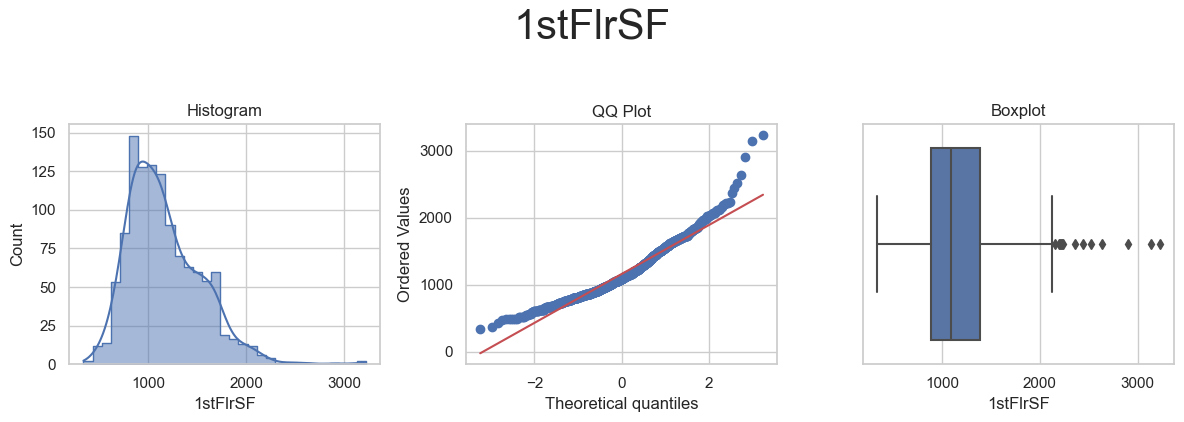

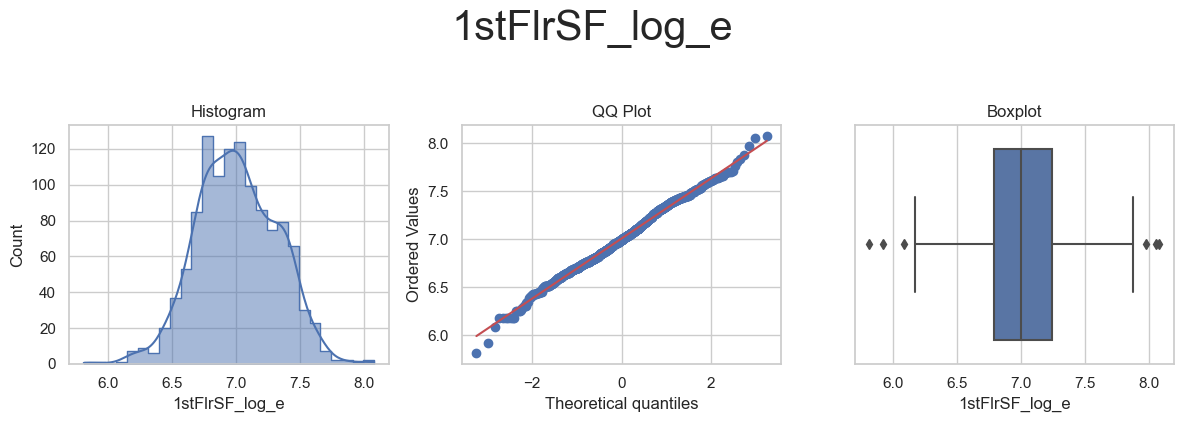

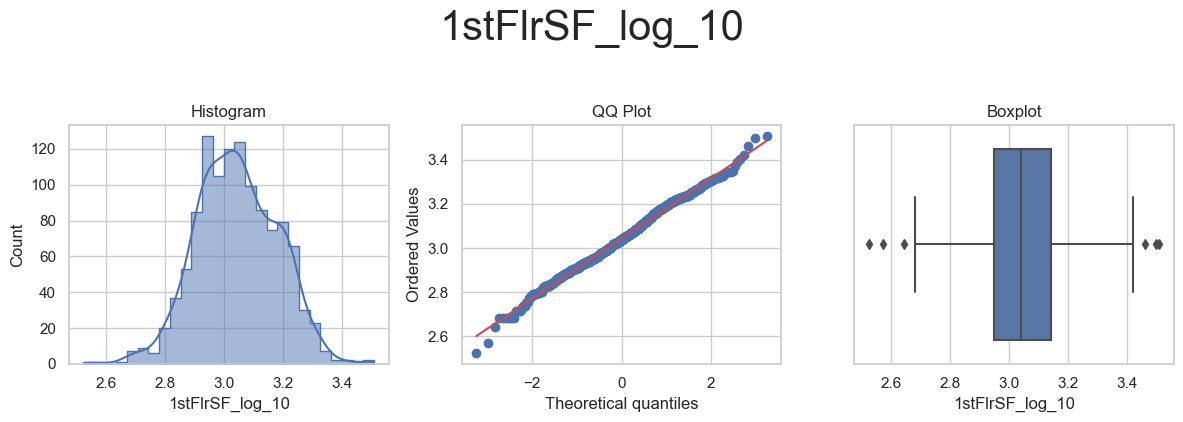

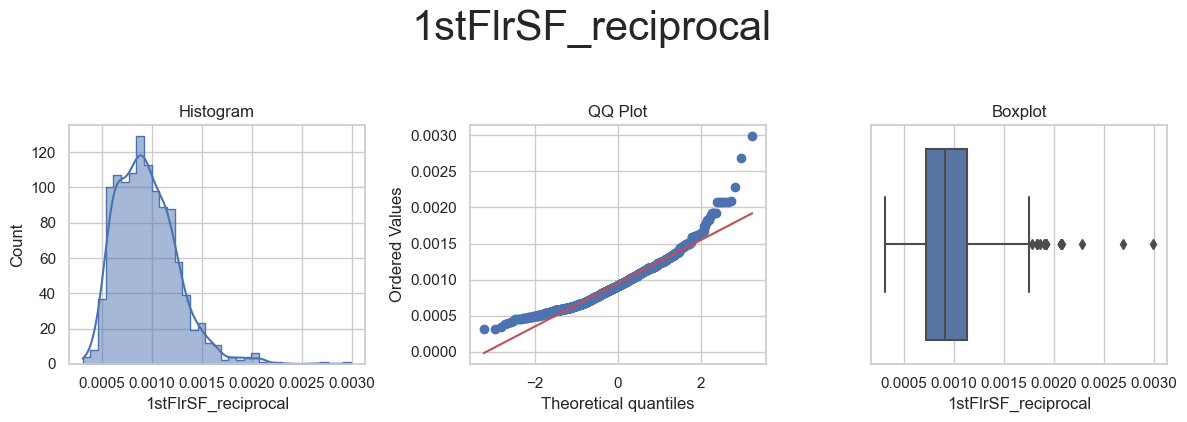

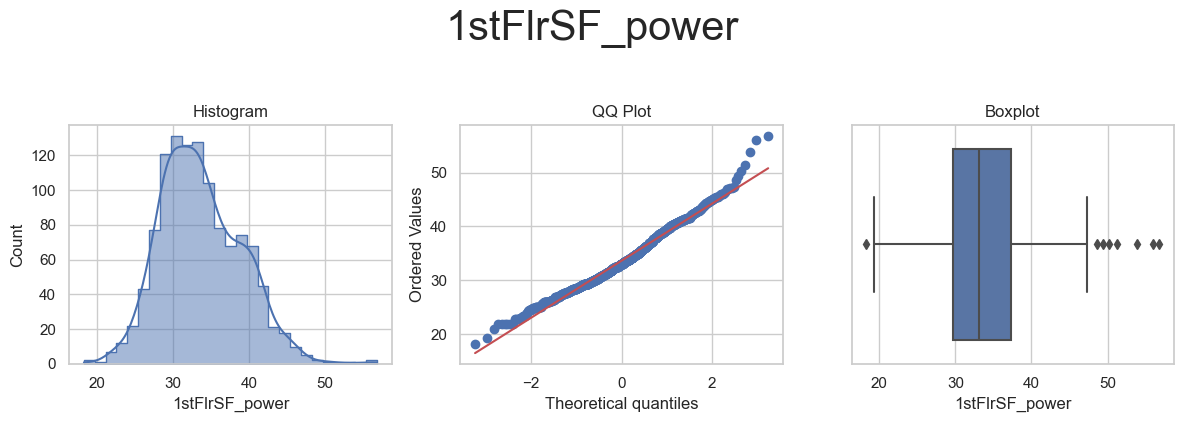

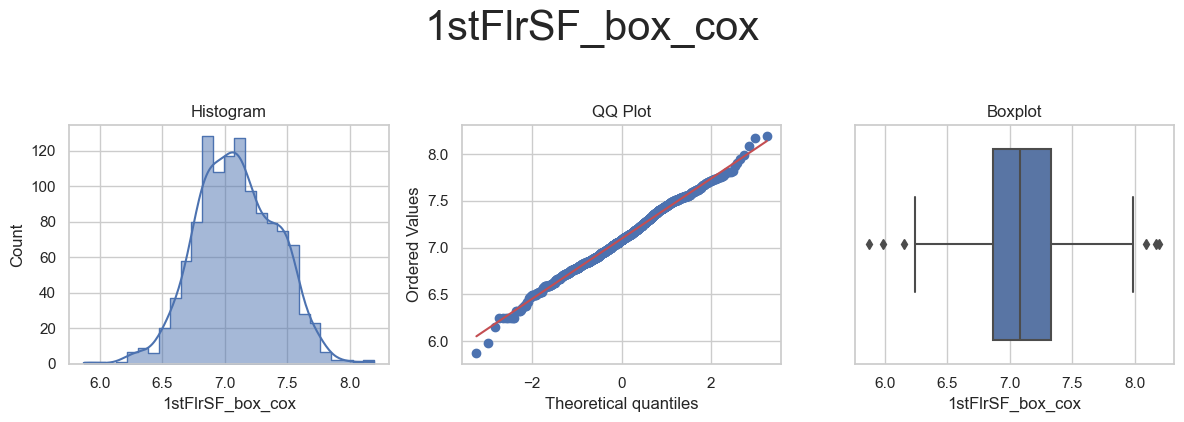

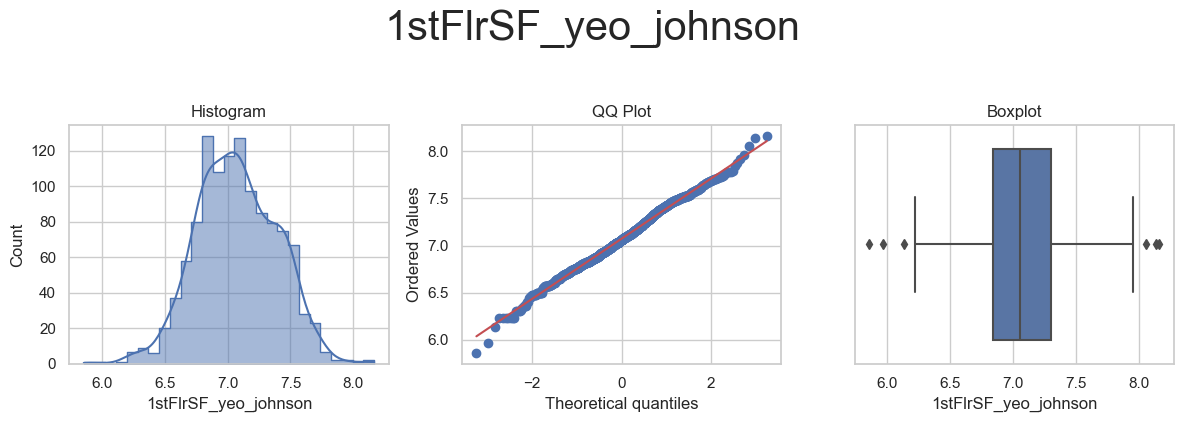



* Variable Analyzed: 2ndFlrSF
* Applied transformation: ['2ndFlrSF_power', '2ndFlrSF_yeo_johnson'] 



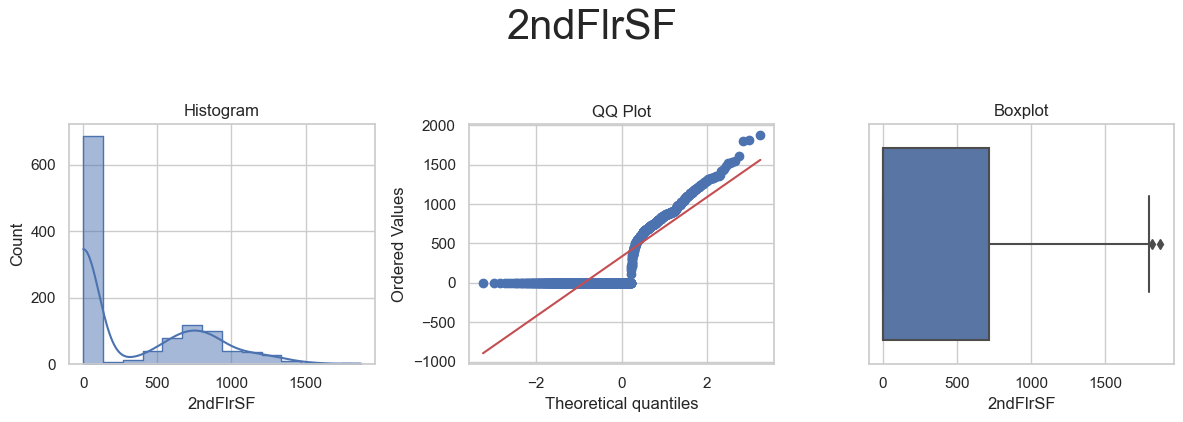

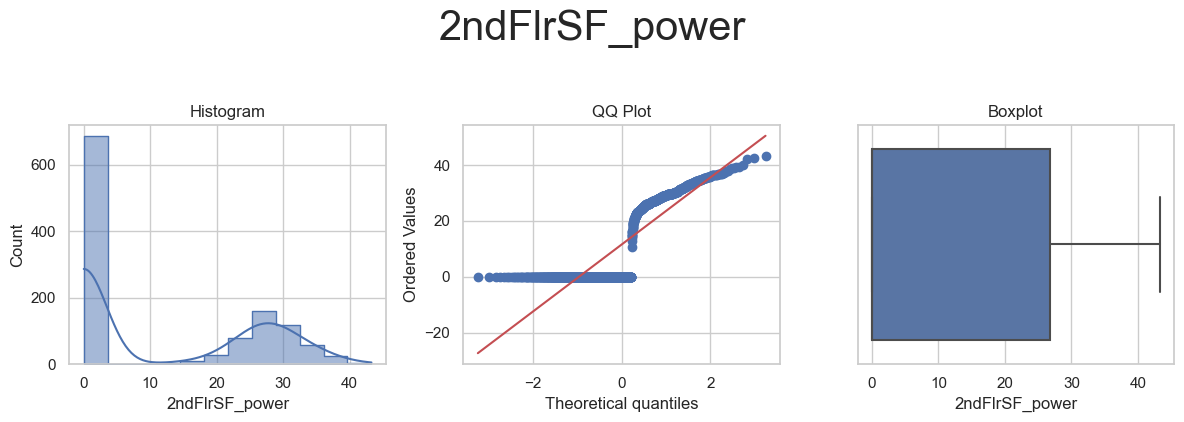

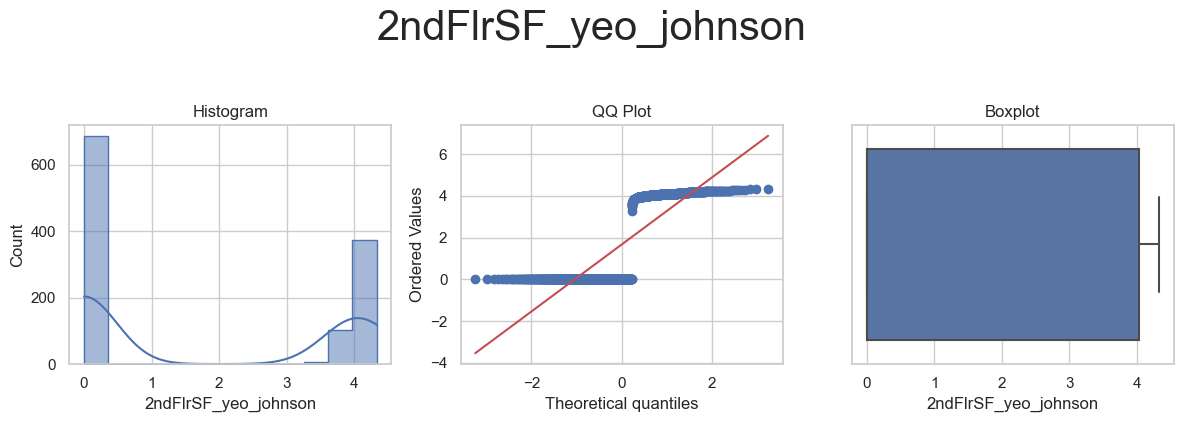



* Variable Analyzed: BedroomAbvGr
* Applied transformation: ['BedroomAbvGr_power', 'BedroomAbvGr_yeo_johnson'] 



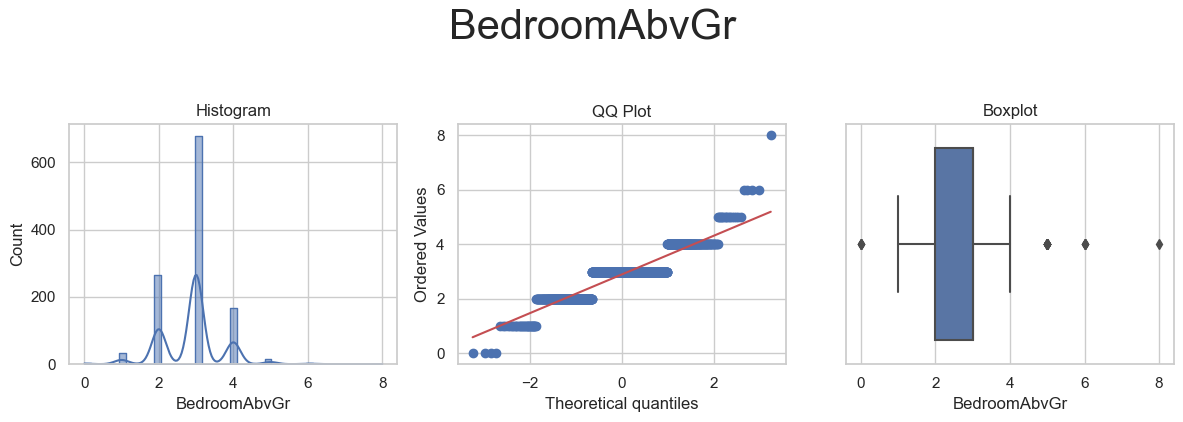

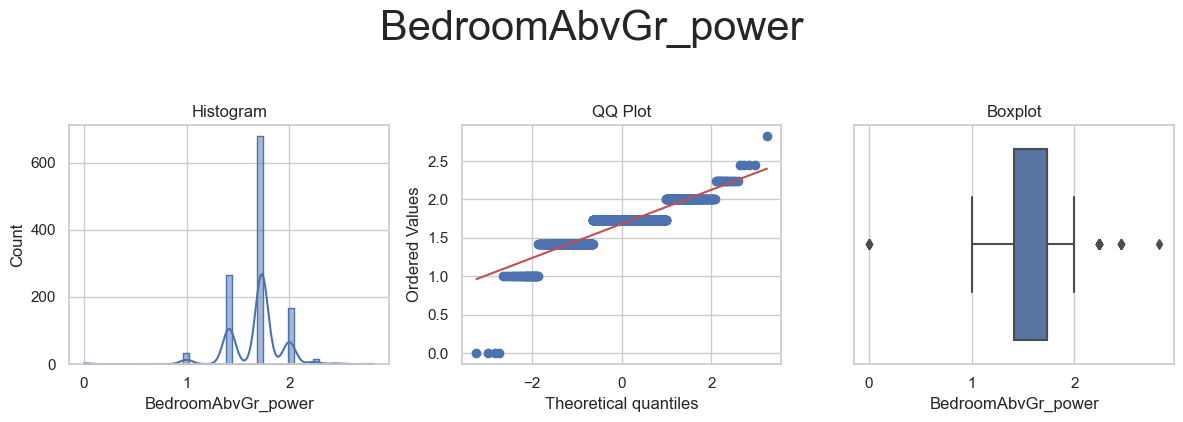

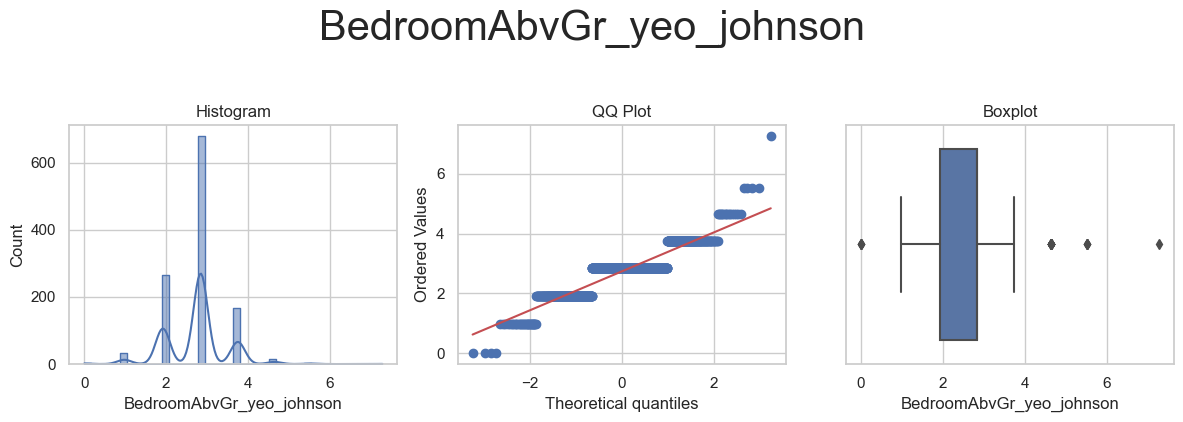



* Variable Analyzed: BsmtFinSF1
* Applied transformation: ['BsmtFinSF1_power', 'BsmtFinSF1_yeo_johnson'] 



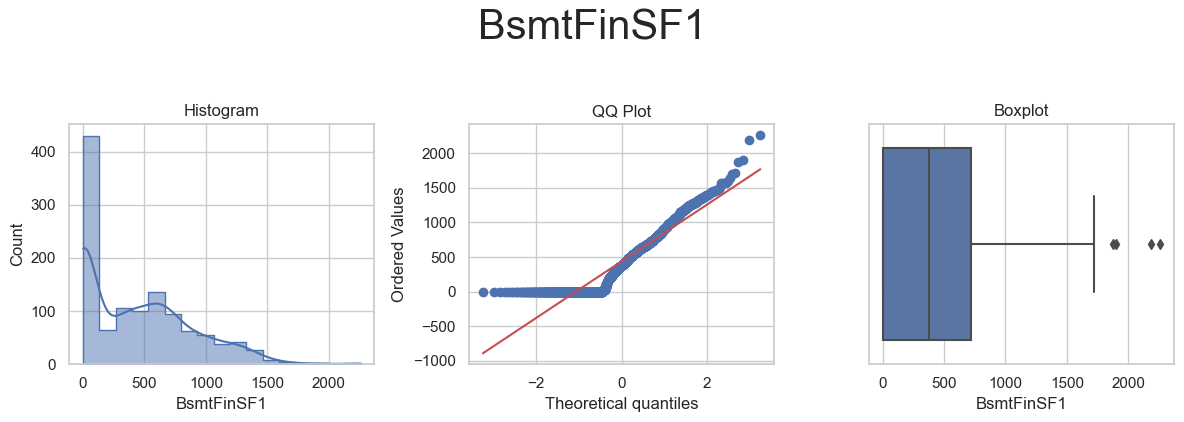

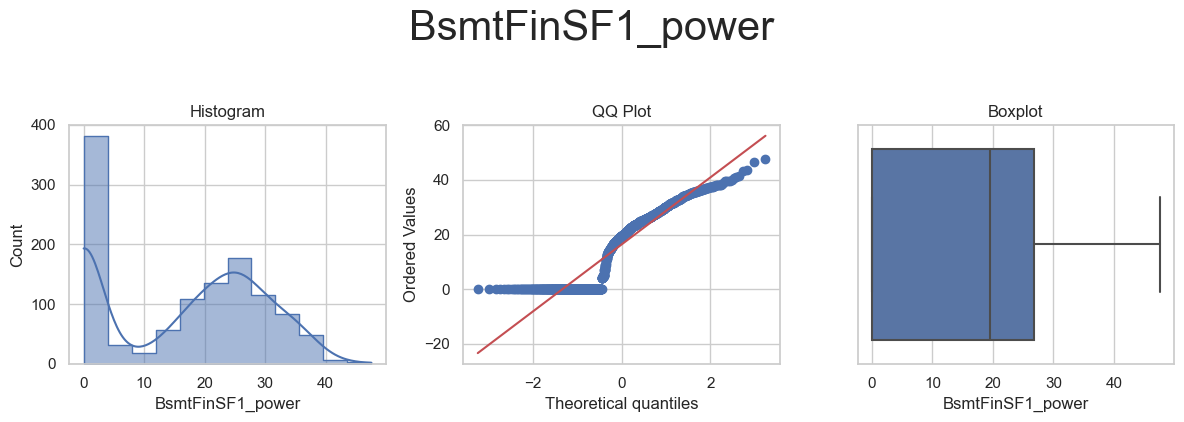

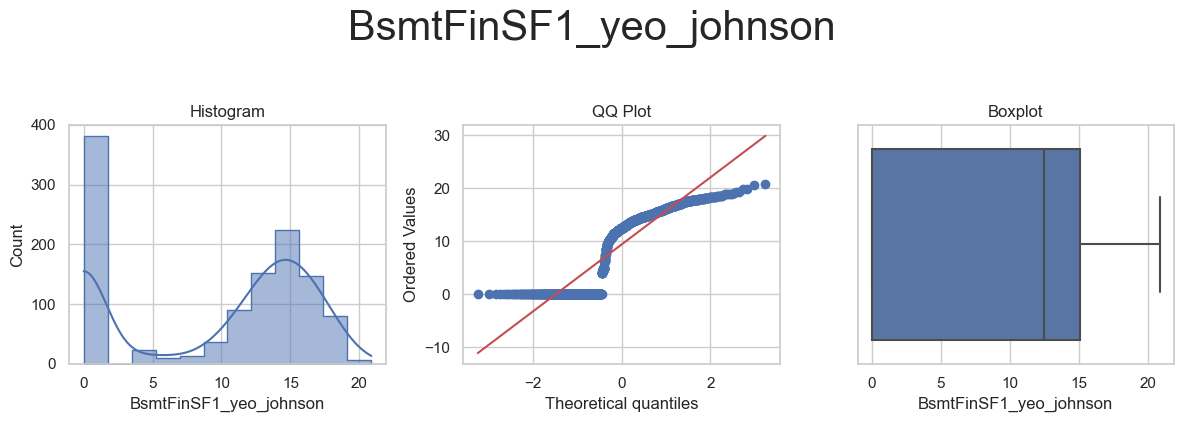



* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_power', 'BsmtFinType1_yeo_johnson'] 



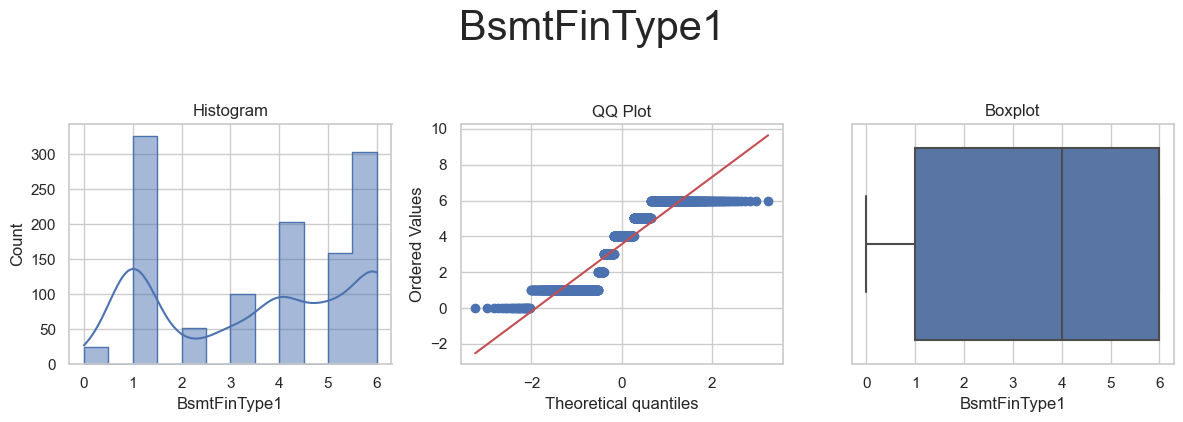

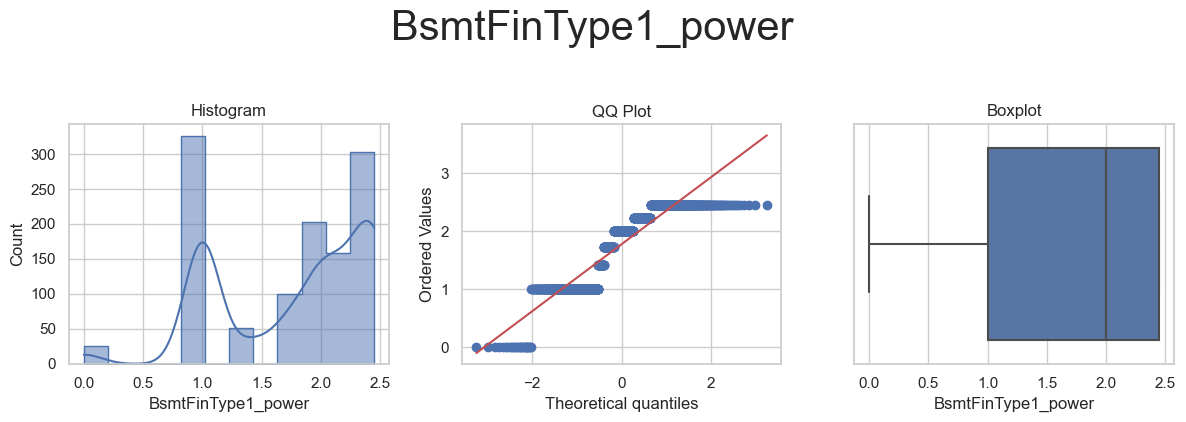

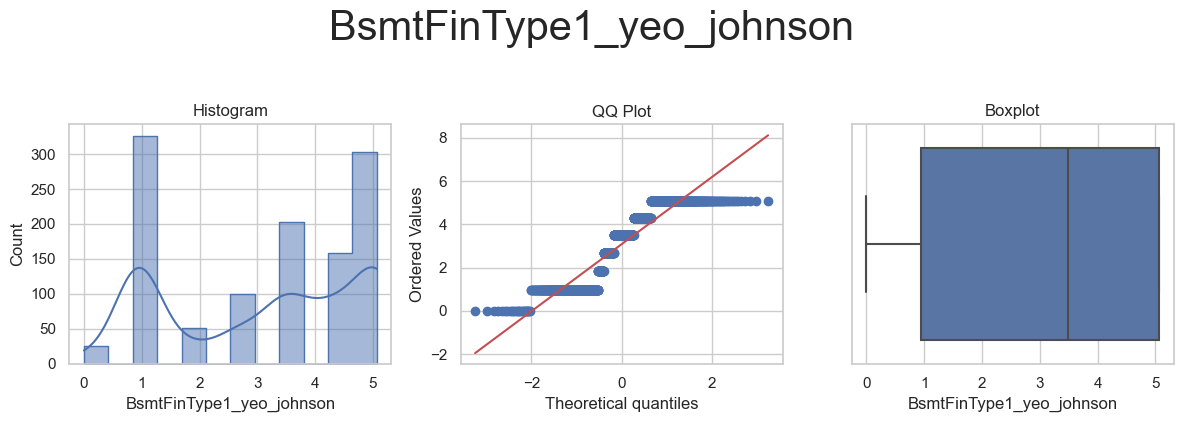



* Variable Analyzed: BsmtUnfSF
* Applied transformation: ['BsmtUnfSF_power', 'BsmtUnfSF_yeo_johnson'] 



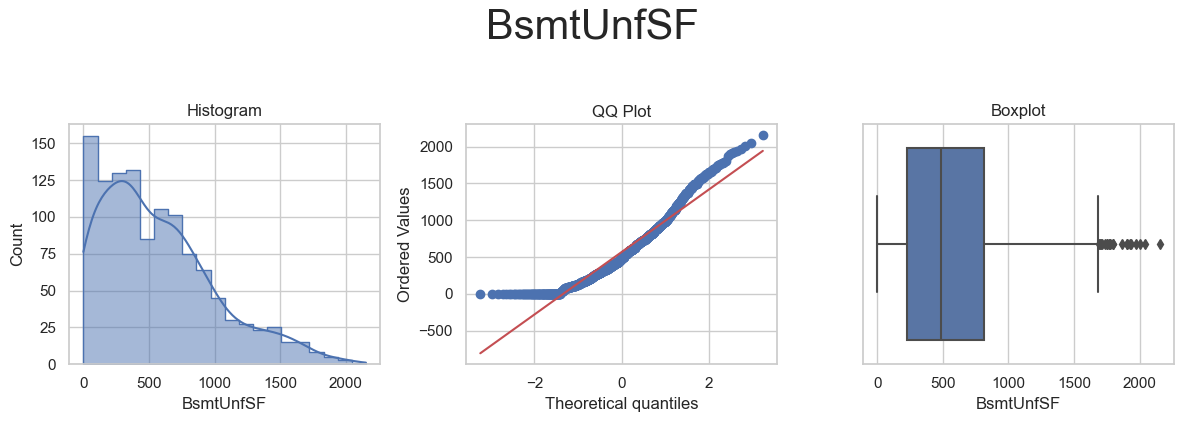

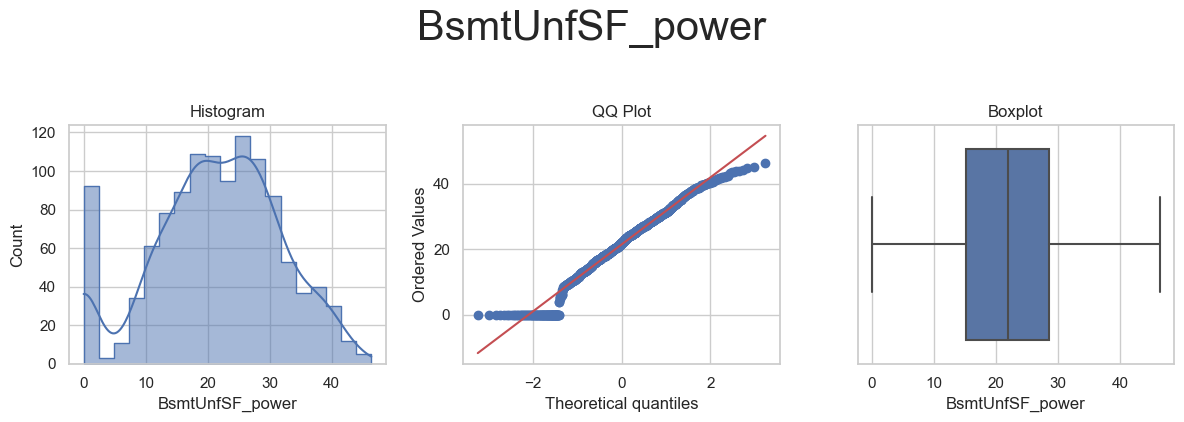

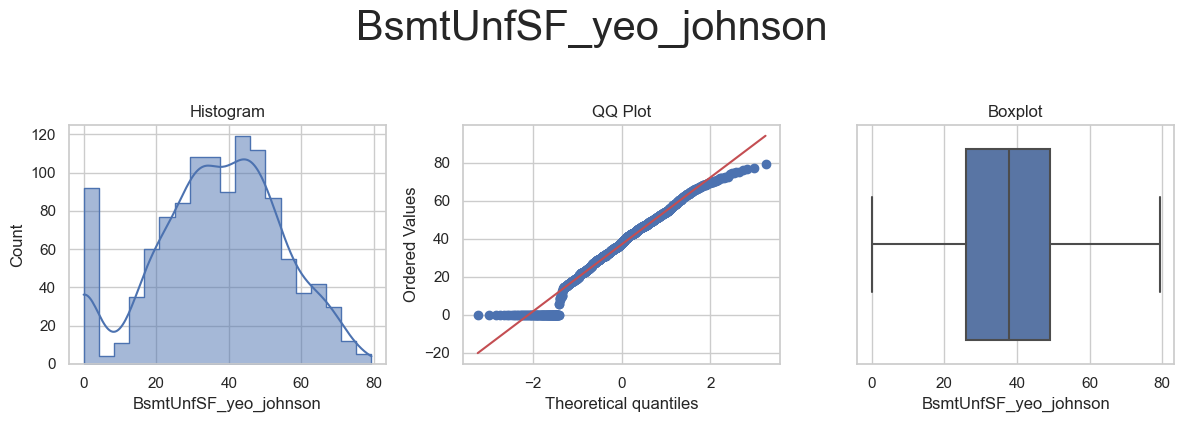



* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_power', 'GarageArea_yeo_johnson'] 



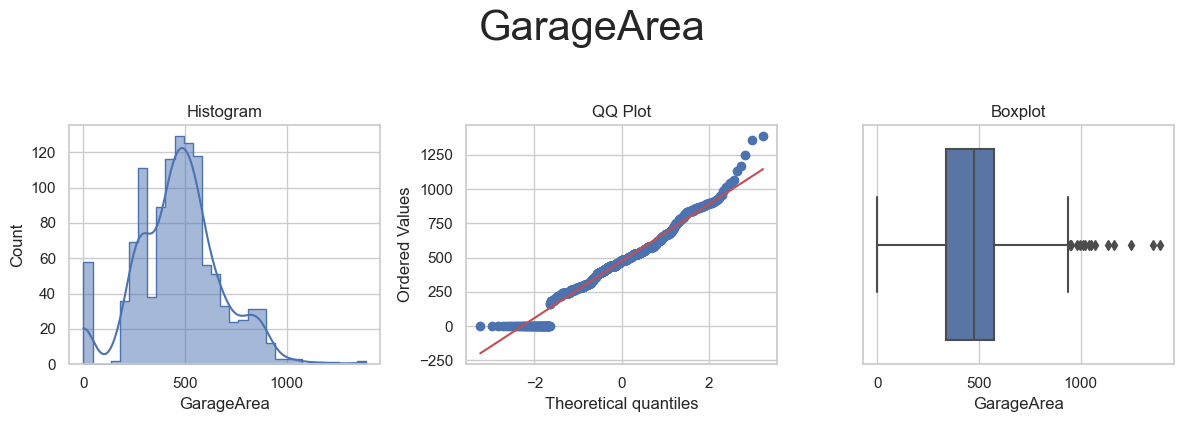

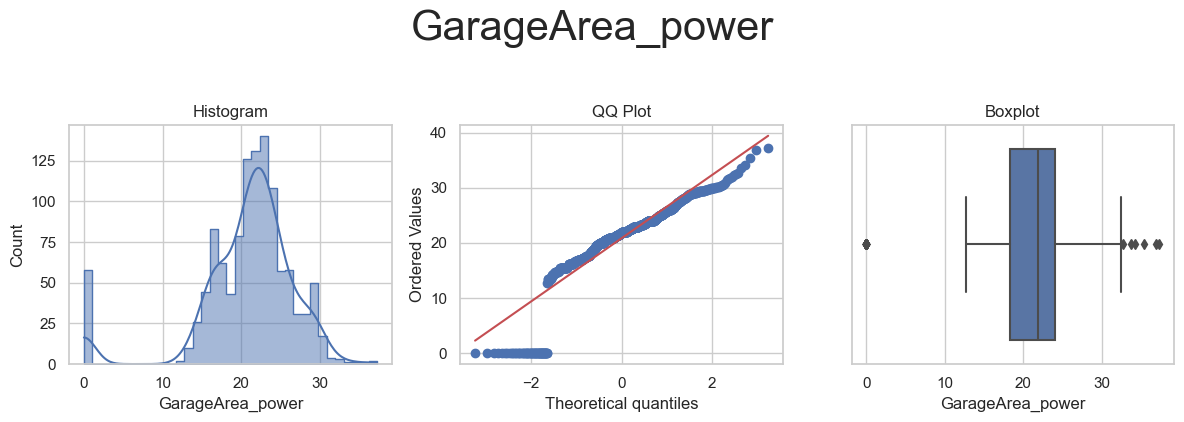

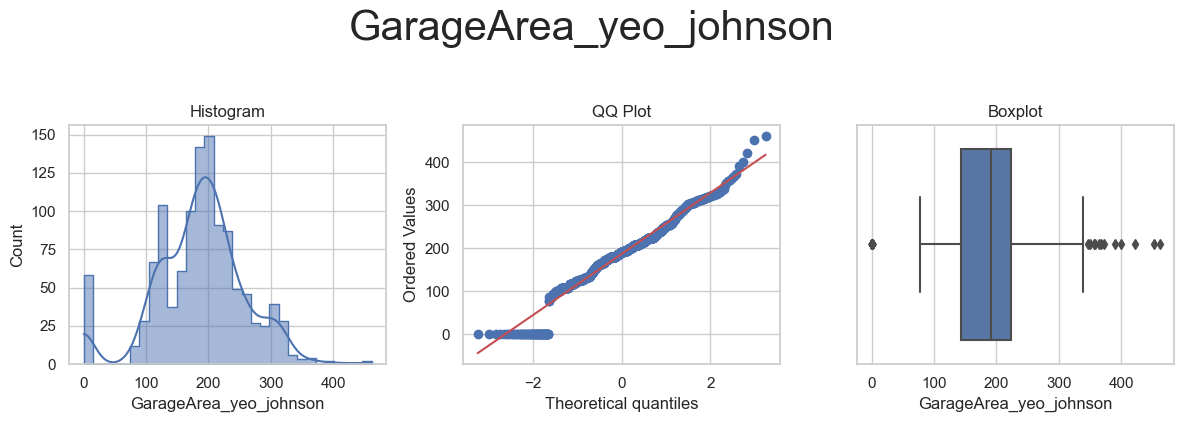



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_power', 'GarageFinish_yeo_johnson'] 



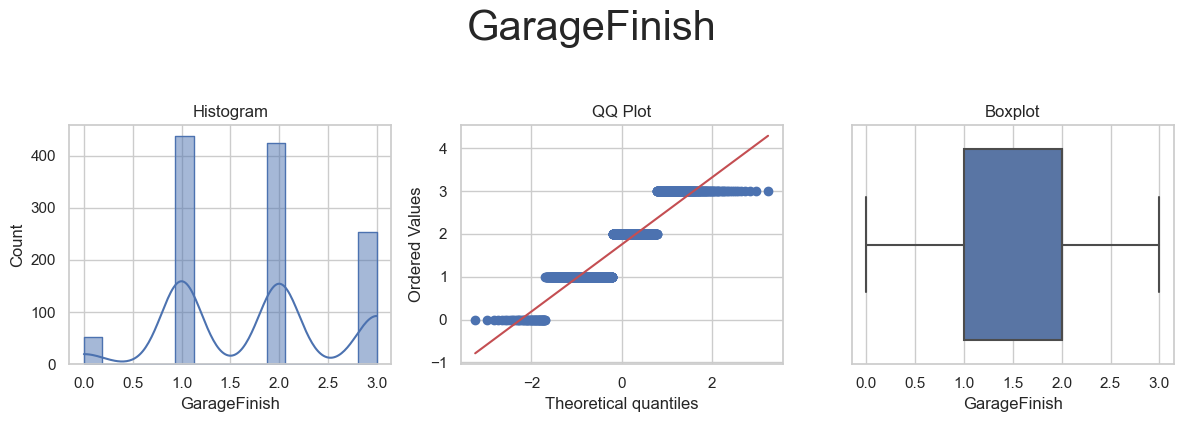

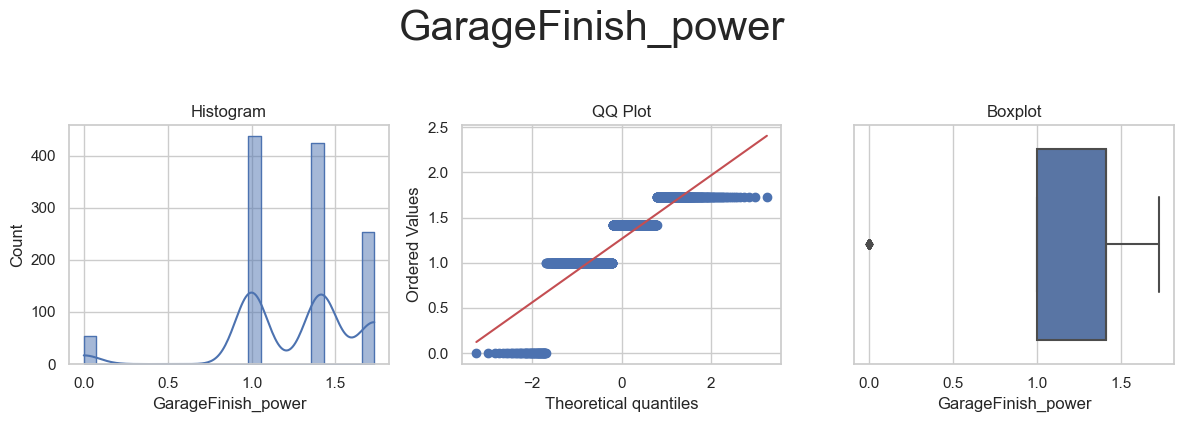

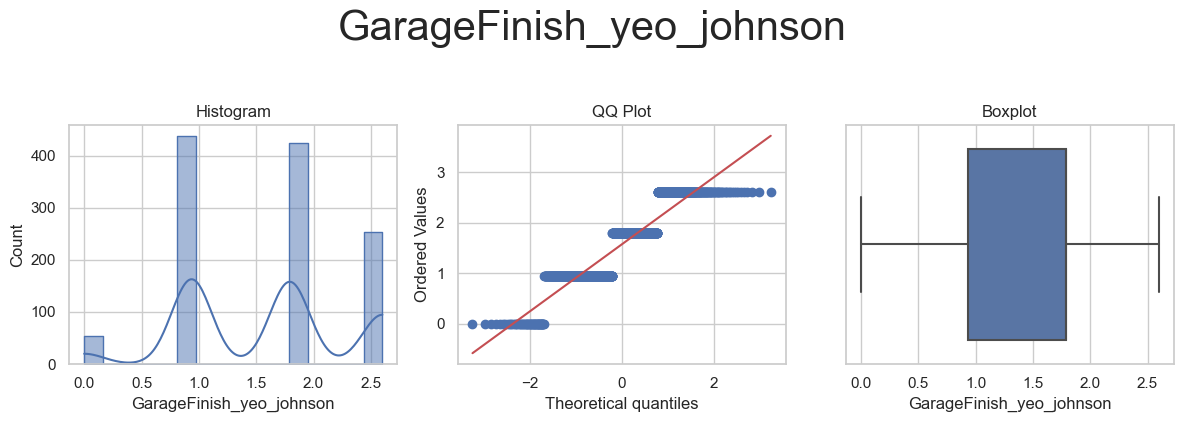



* Variable Analyzed: GarageYrBlt
* Applied transformation: ['GarageYrBlt_log_e', 'GarageYrBlt_log_10', 'GarageYrBlt_reciprocal', 'GarageYrBlt_power', 'GarageYrBlt_box_cox', 'GarageYrBlt_yeo_johnson'] 



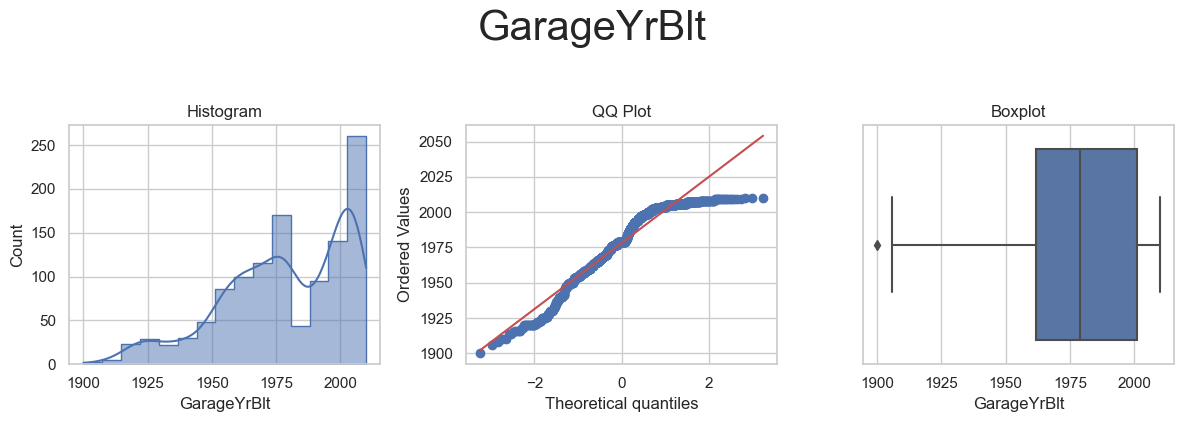

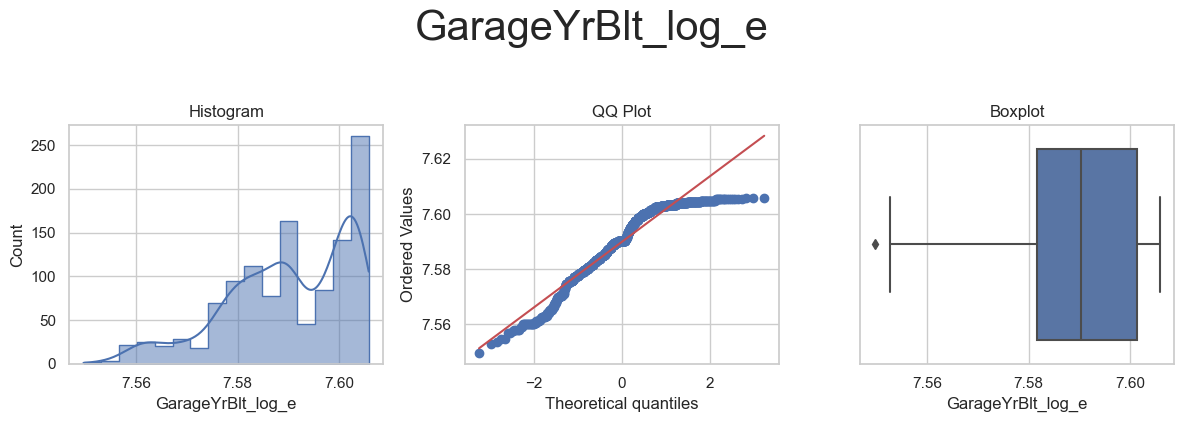

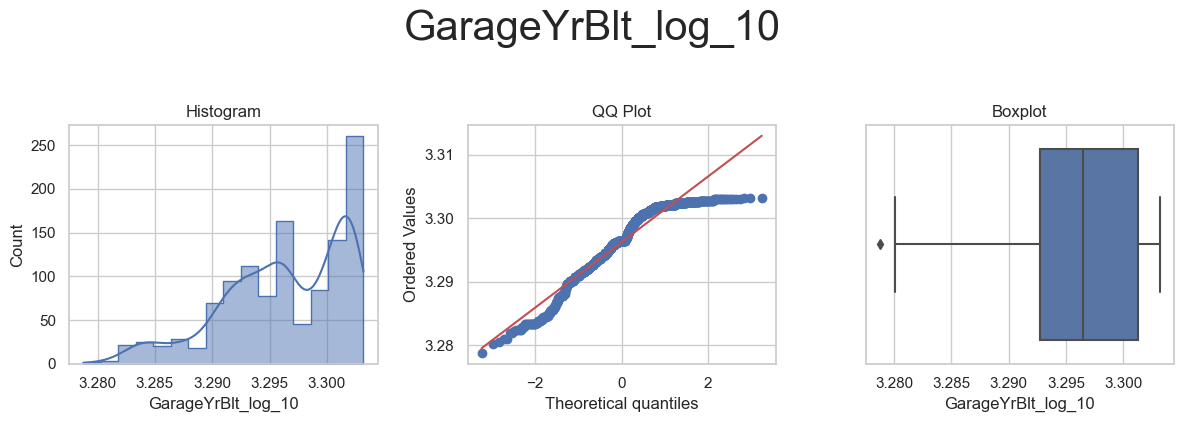

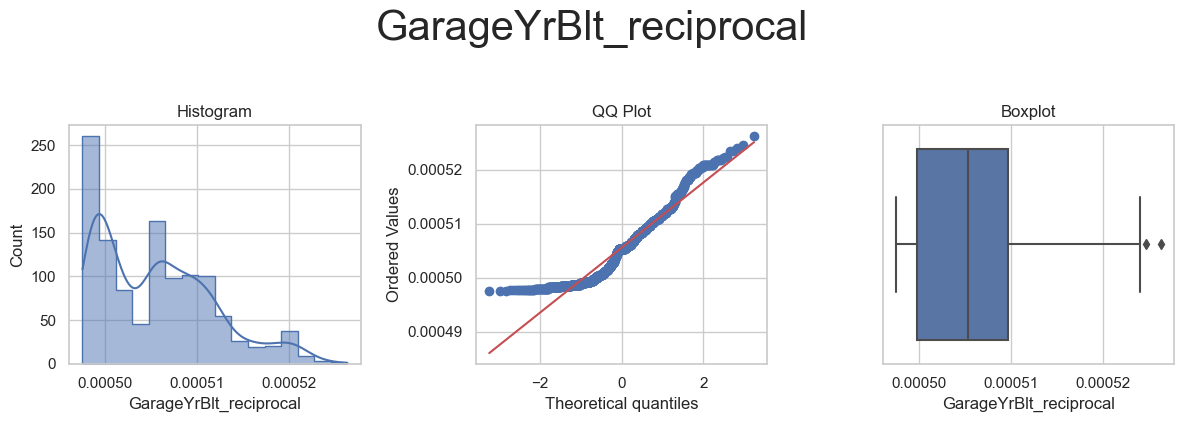

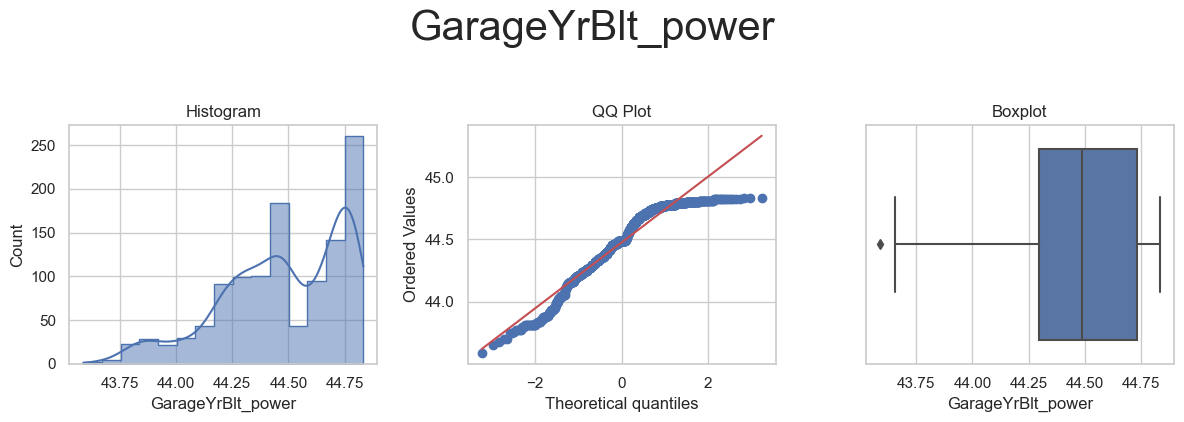

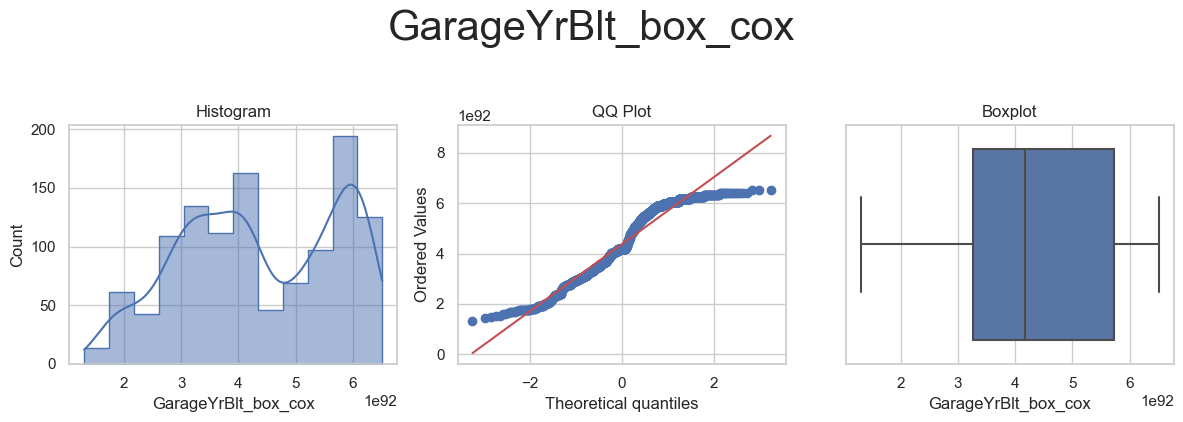

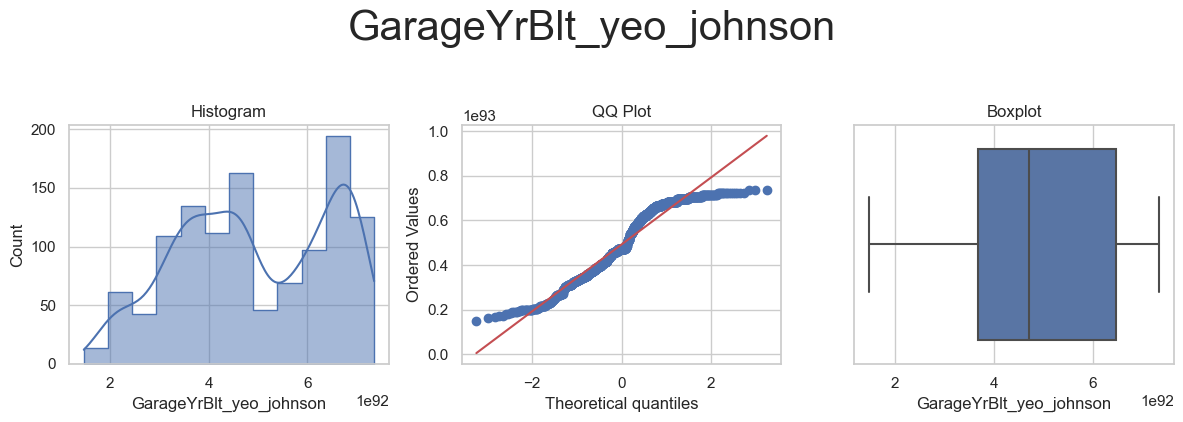



* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



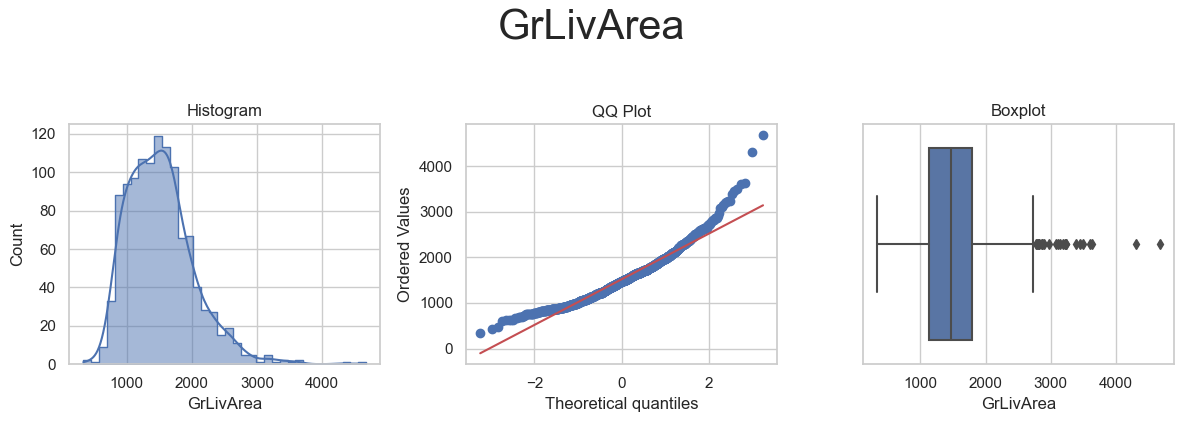

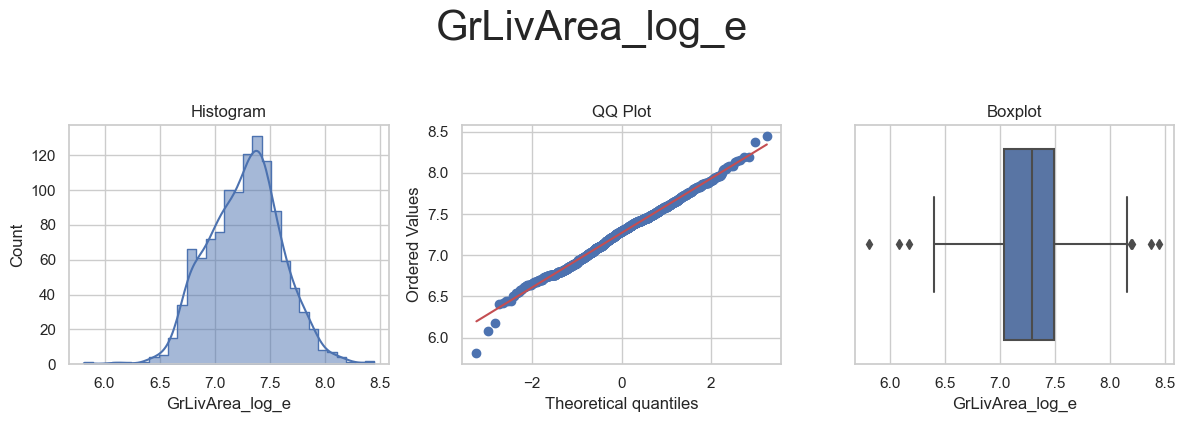

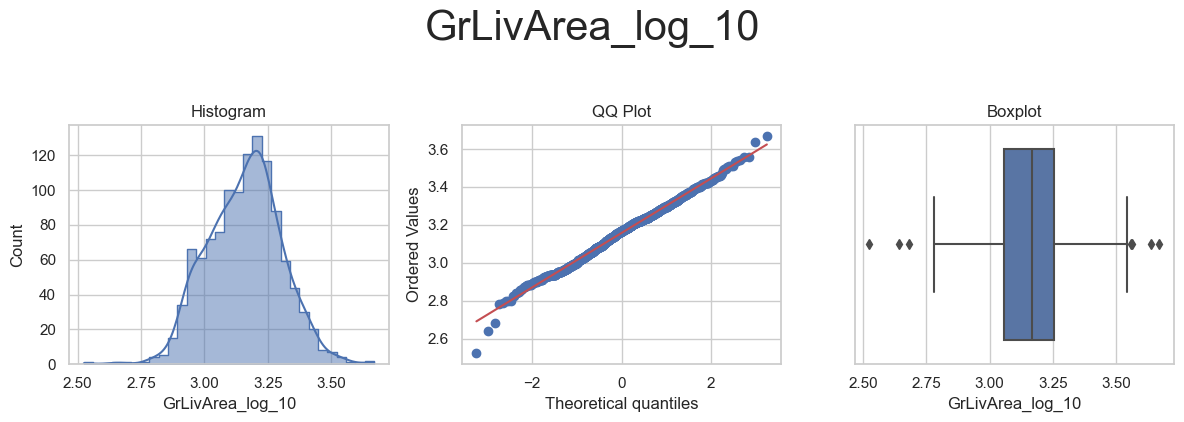

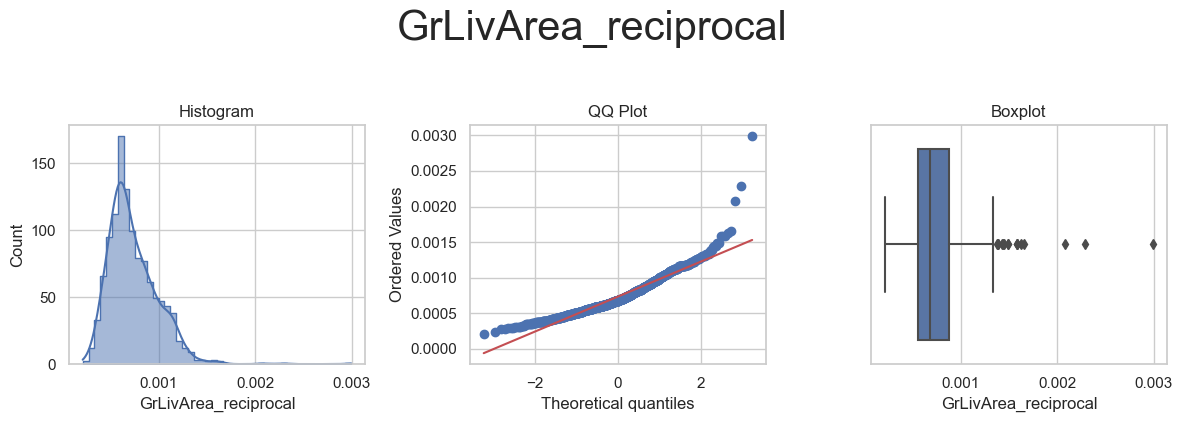

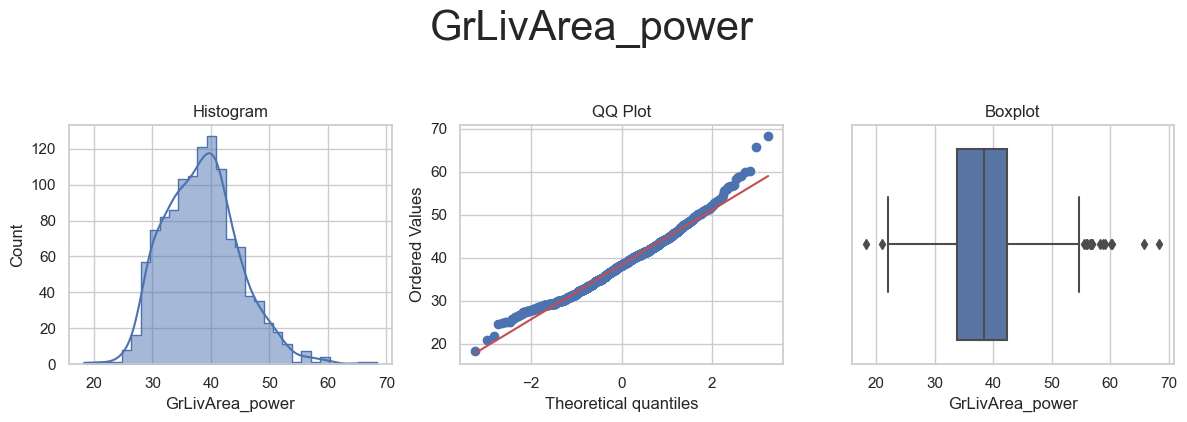

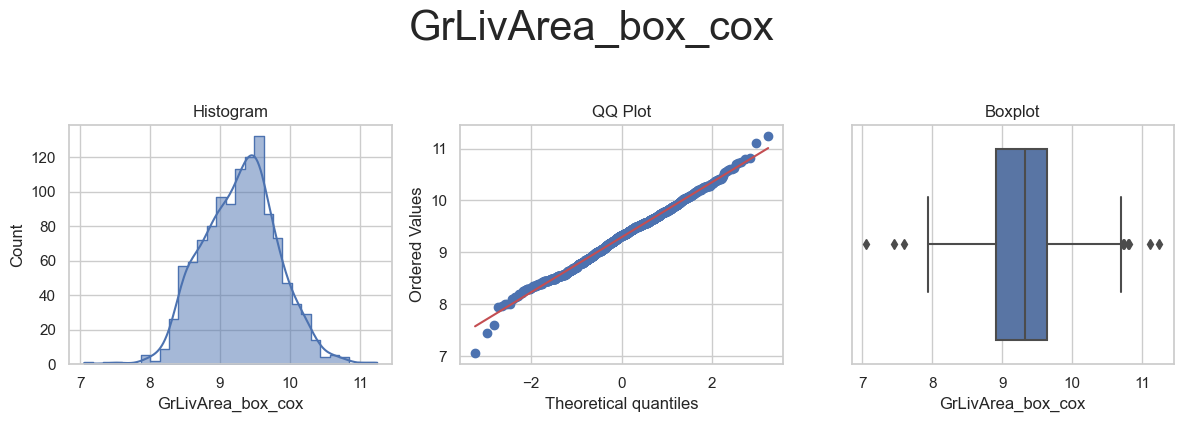

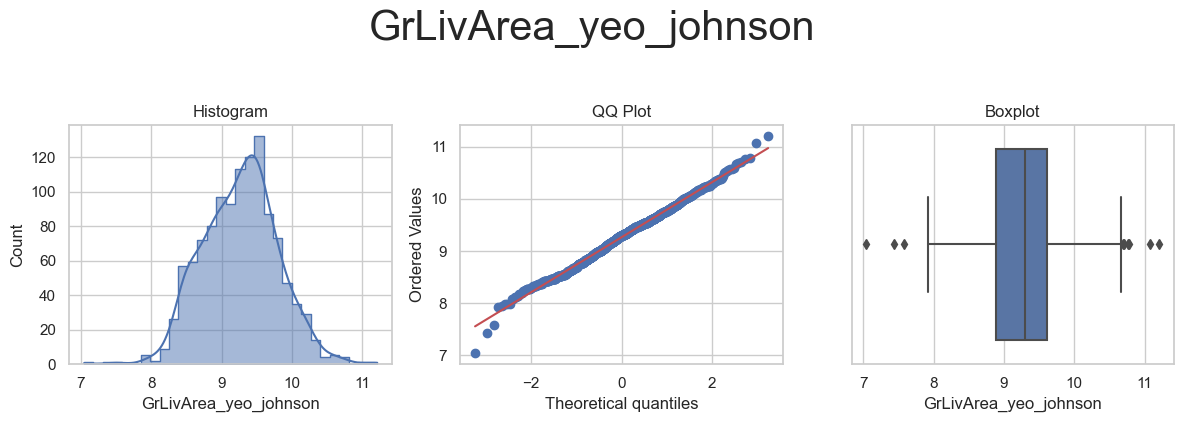



* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_log_e', 'LotArea_log_10', 'LotArea_reciprocal', 'LotArea_power', 'LotArea_box_cox', 'LotArea_yeo_johnson'] 



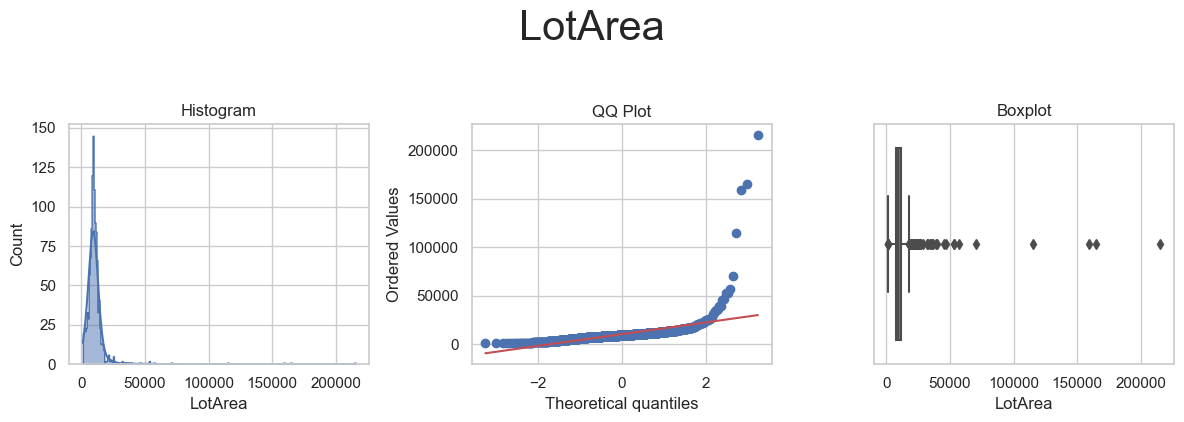

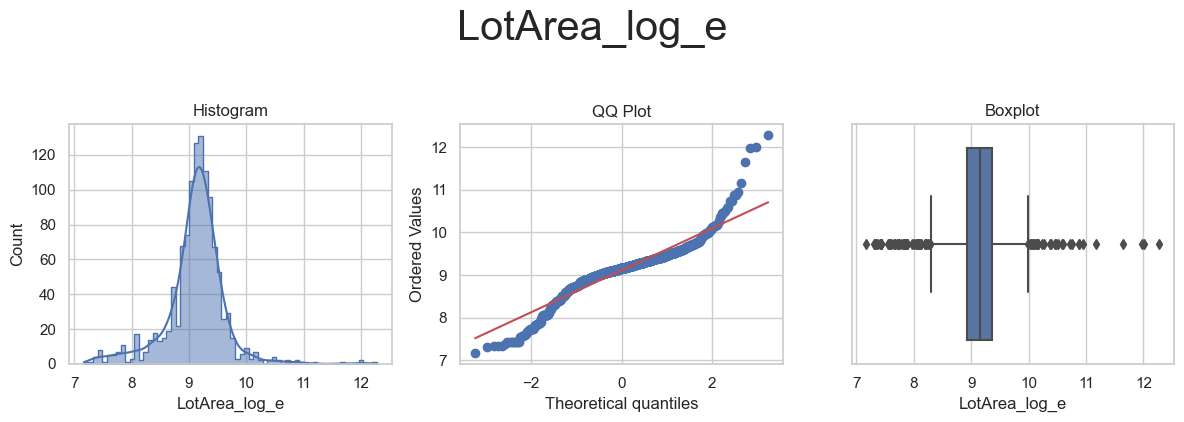

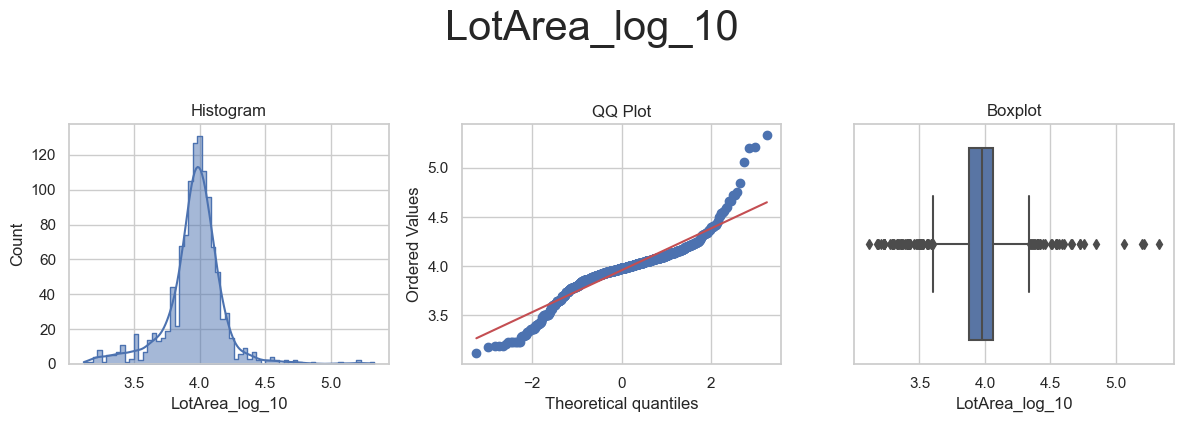

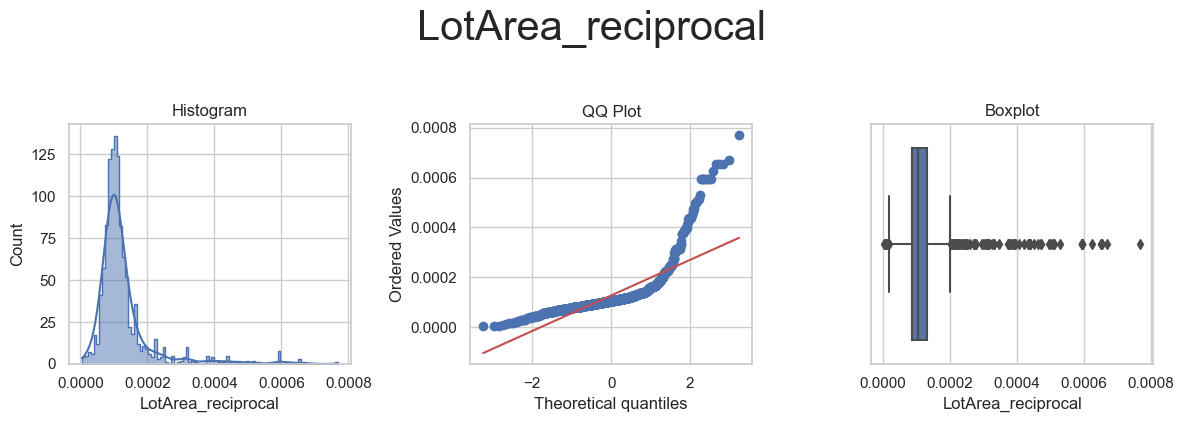

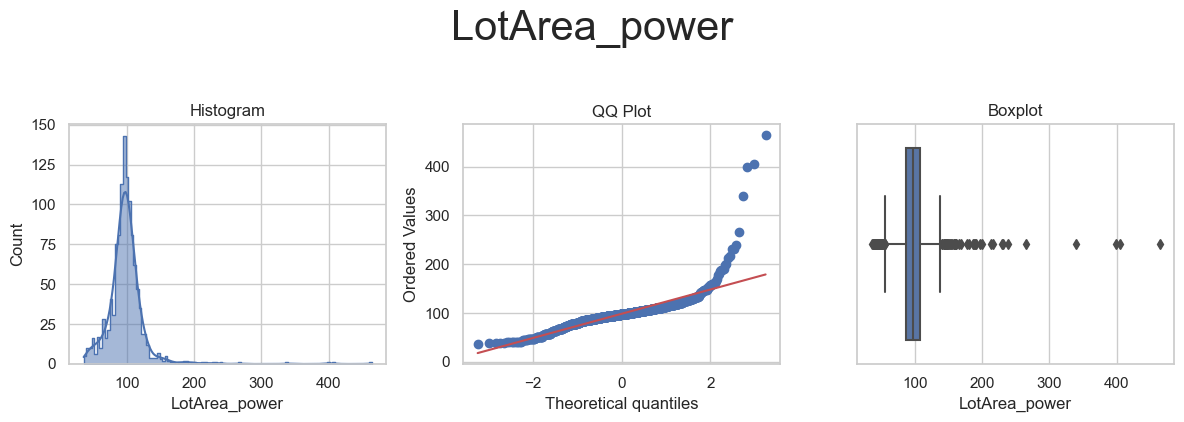

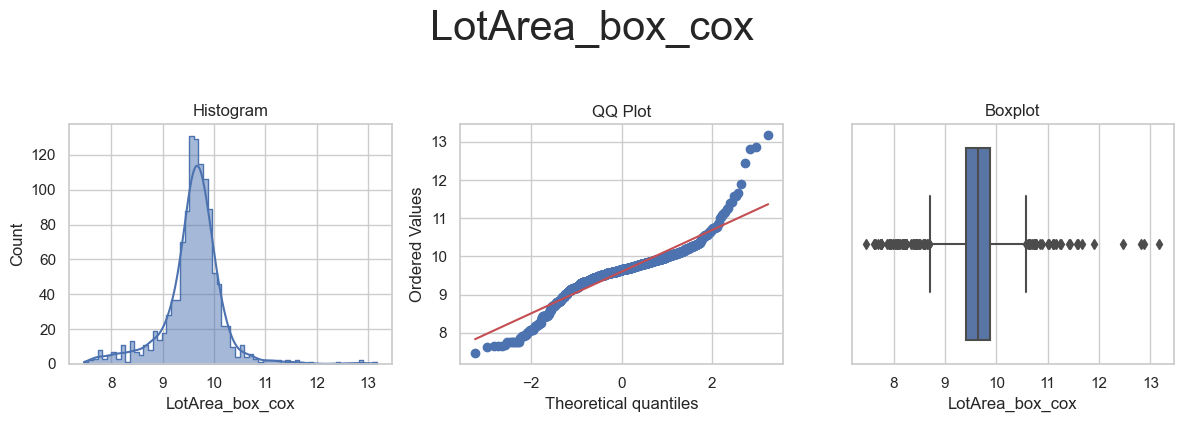

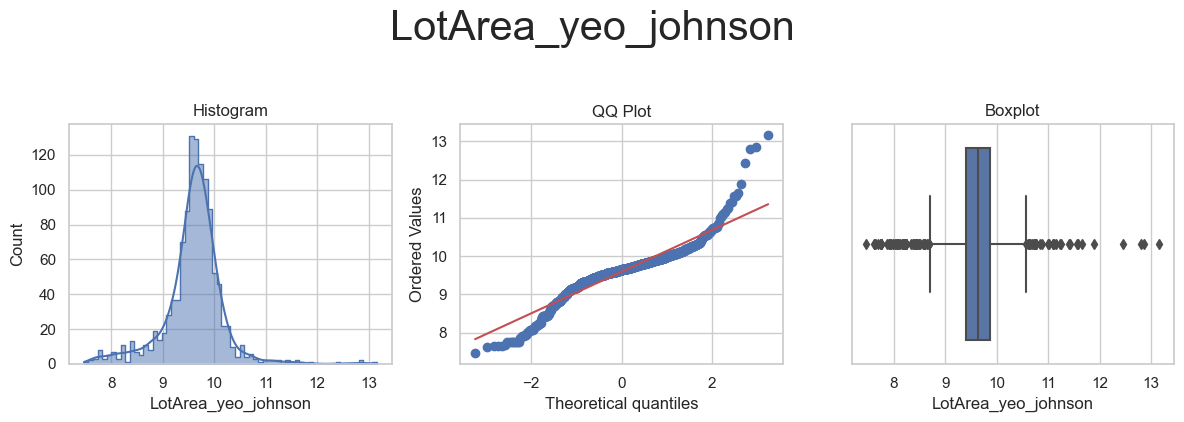



* Variable Analyzed: LotFrontage
* Applied transformation: ['LotFrontage_log_e', 'LotFrontage_log_10', 'LotFrontage_reciprocal', 'LotFrontage_power', 'LotFrontage_box_cox', 'LotFrontage_yeo_johnson'] 



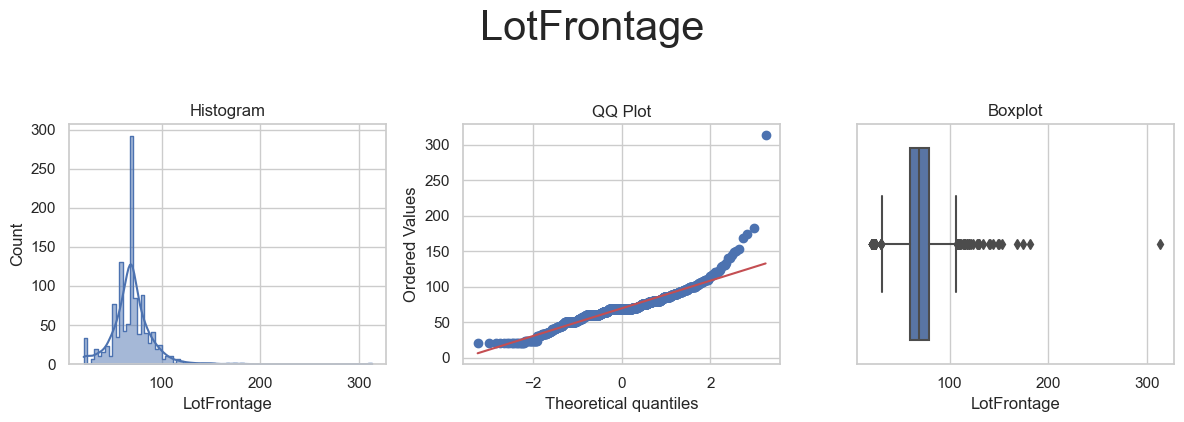

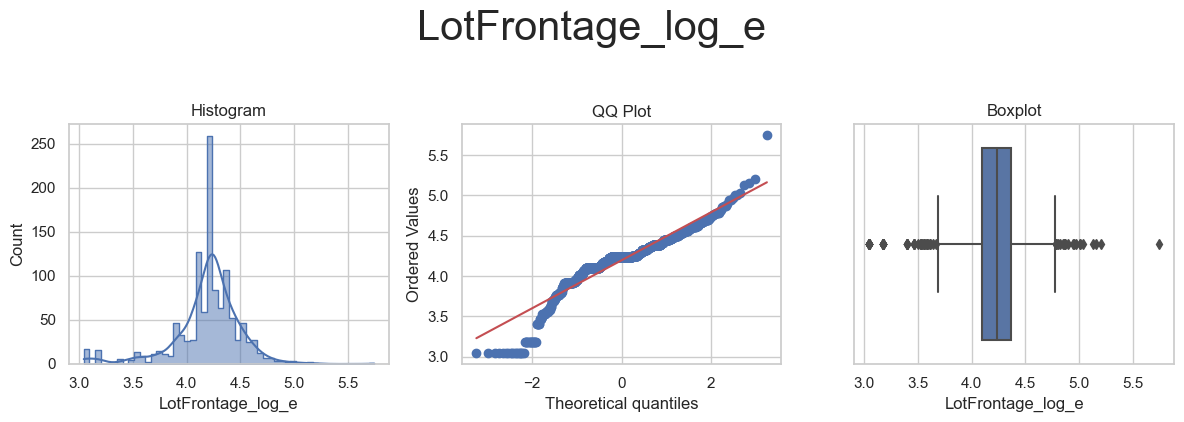

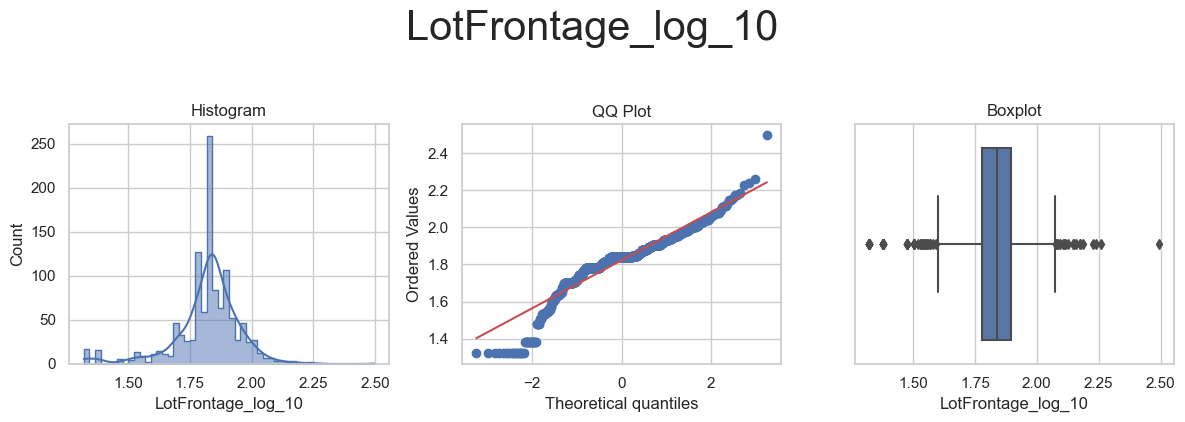

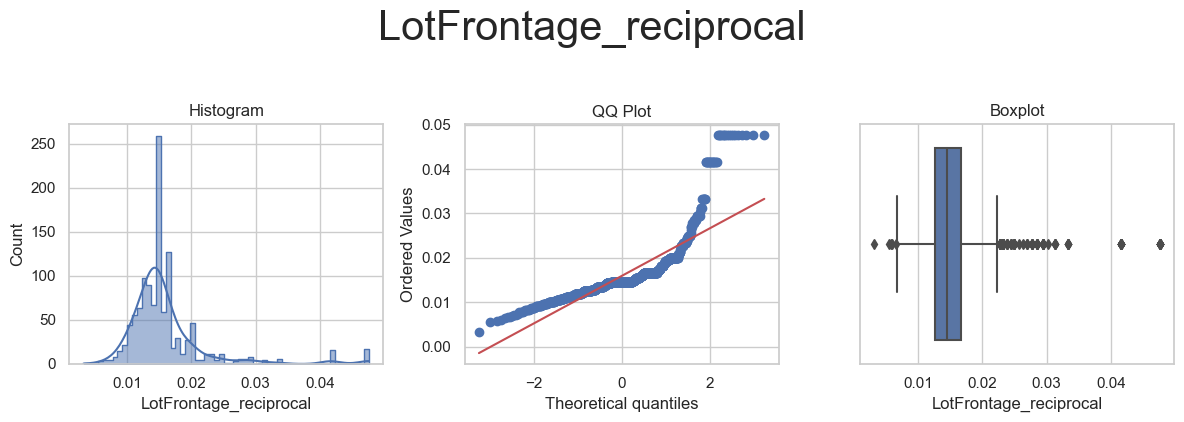

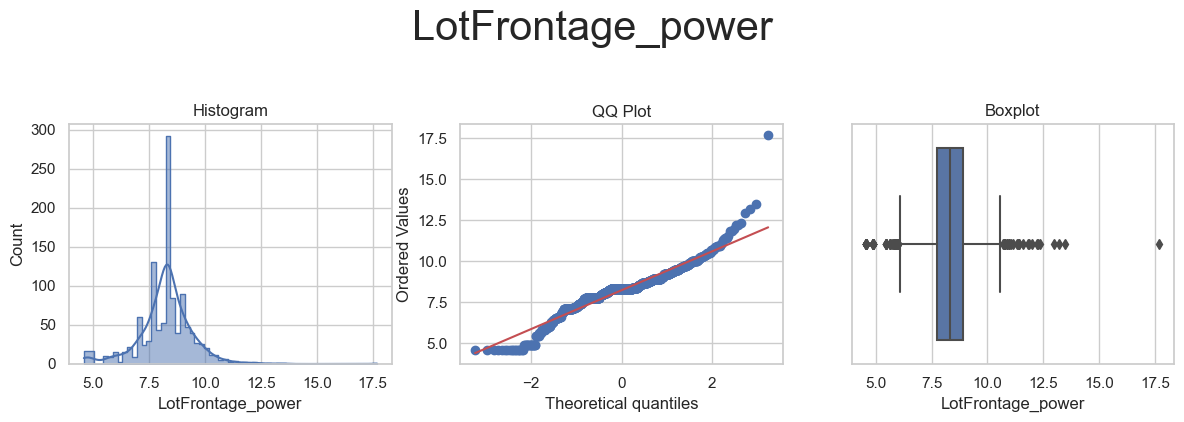

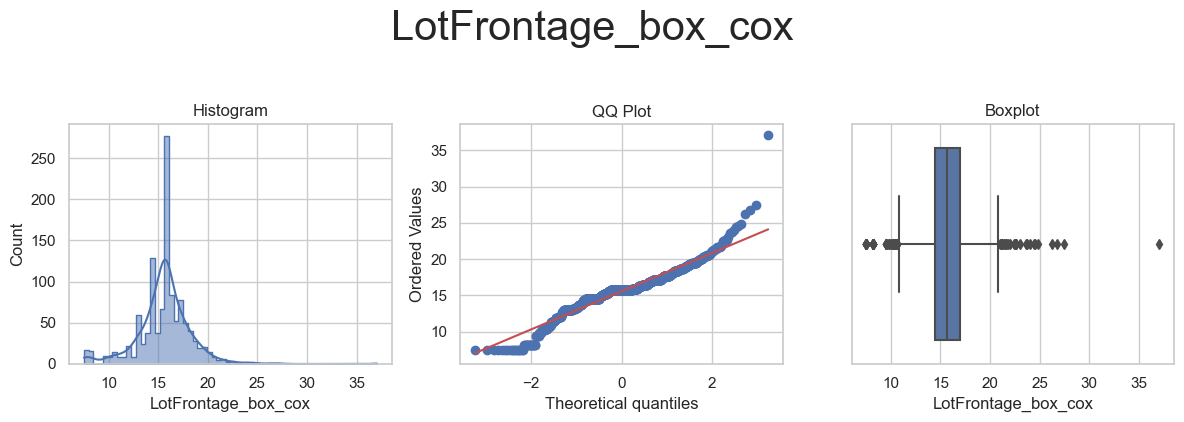

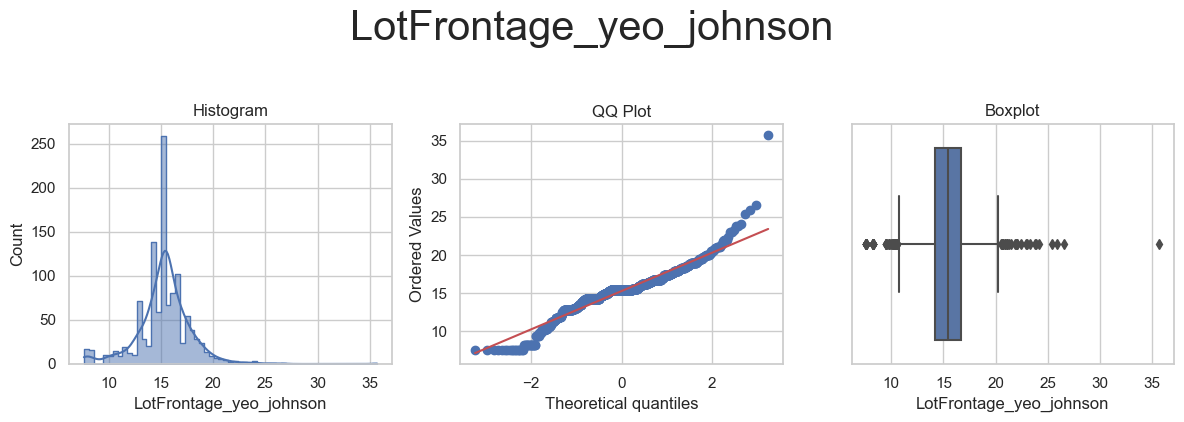



* Variable Analyzed: MasVnrArea
* Applied transformation: ['MasVnrArea_power', 'MasVnrArea_yeo_johnson'] 



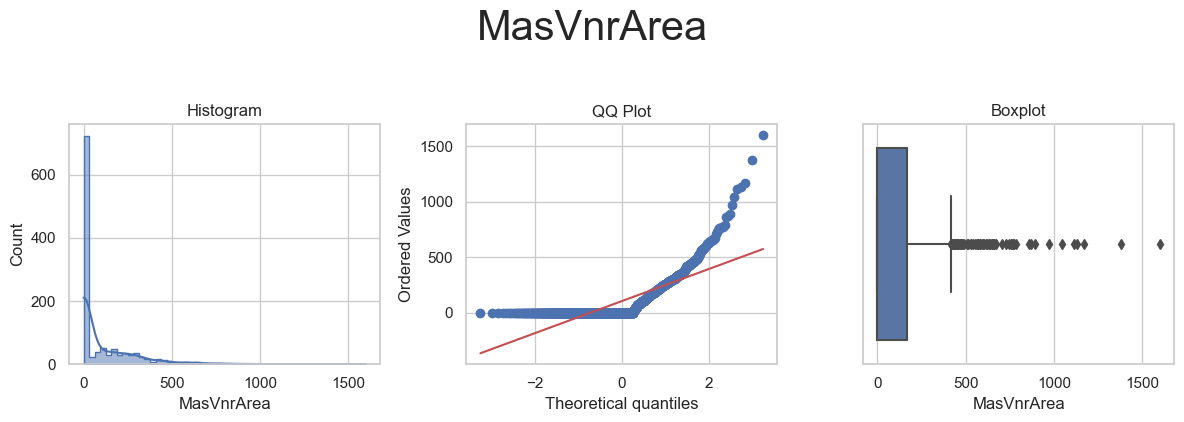

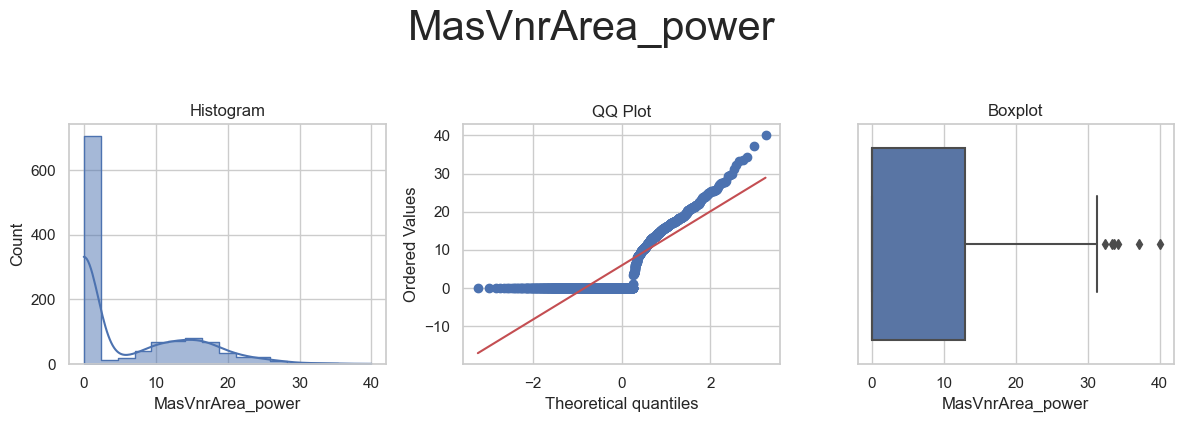

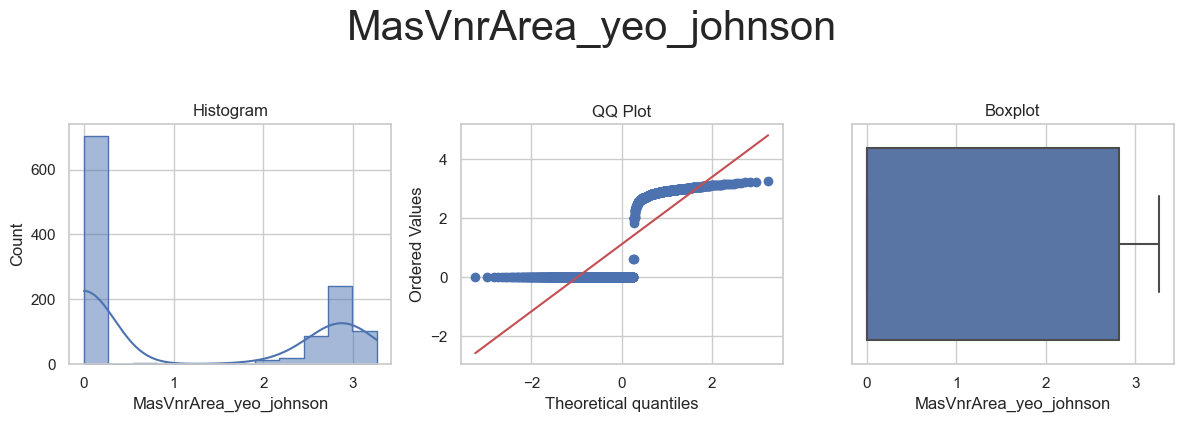



* Variable Analyzed: OpenPorchSF
* Applied transformation: ['OpenPorchSF_power', 'OpenPorchSF_yeo_johnson'] 



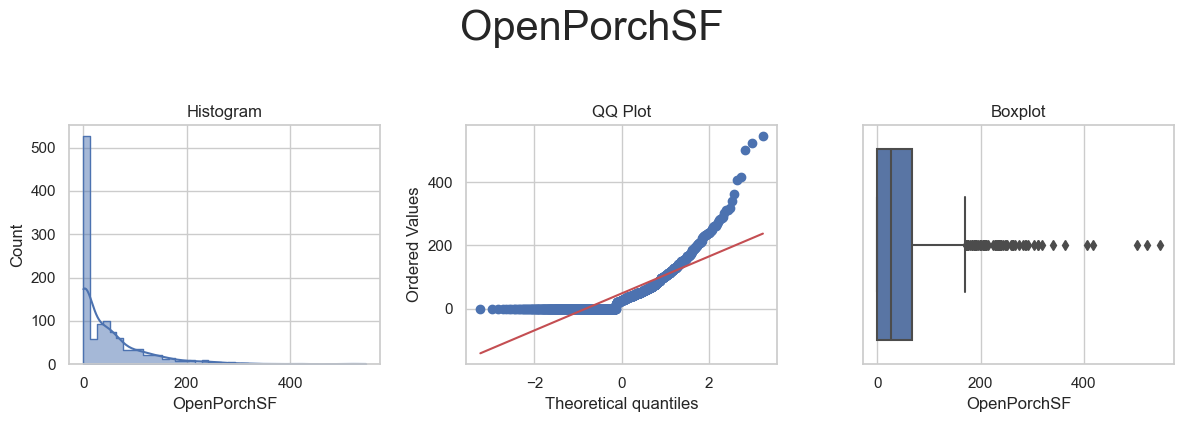

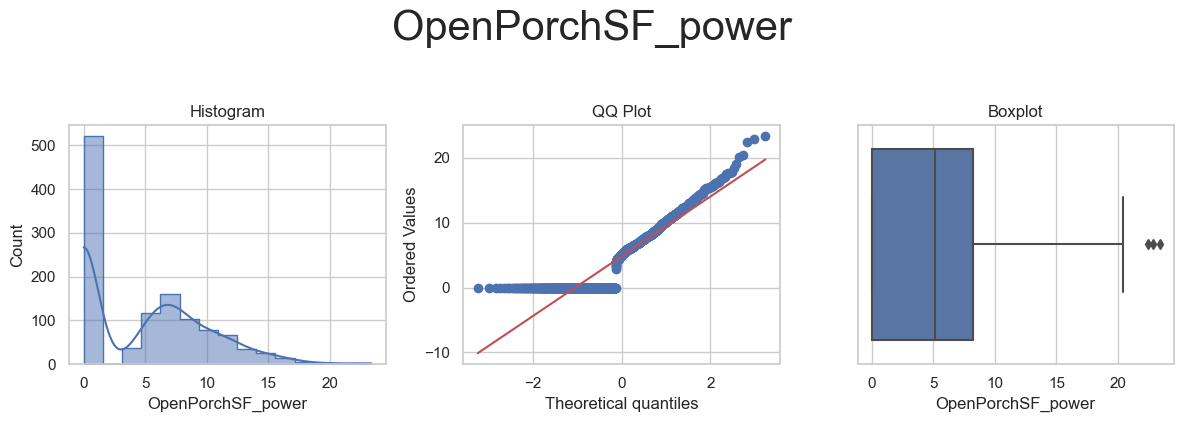

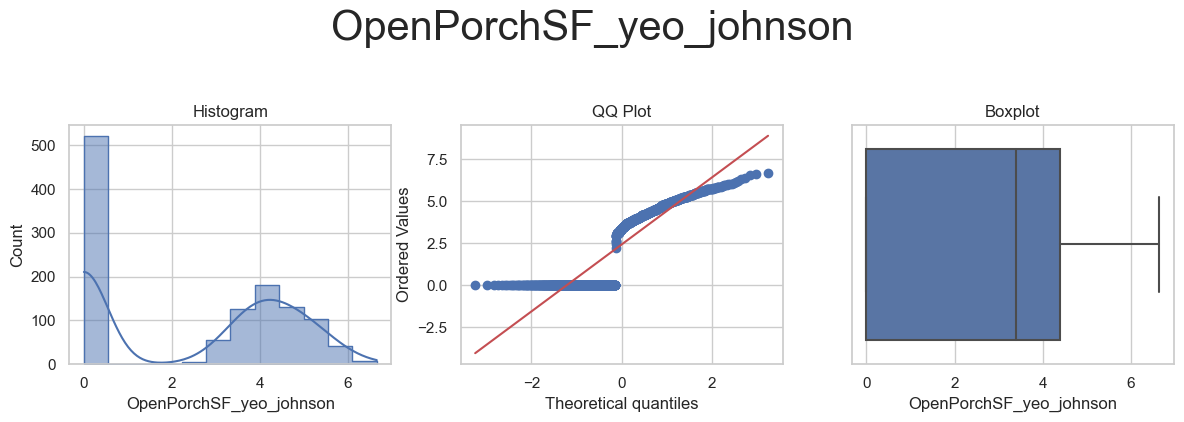



* Variable Analyzed: OverallCond
* Applied transformation: ['OverallCond_log_e', 'OverallCond_log_10', 'OverallCond_reciprocal', 'OverallCond_power', 'OverallCond_box_cox', 'OverallCond_yeo_johnson'] 



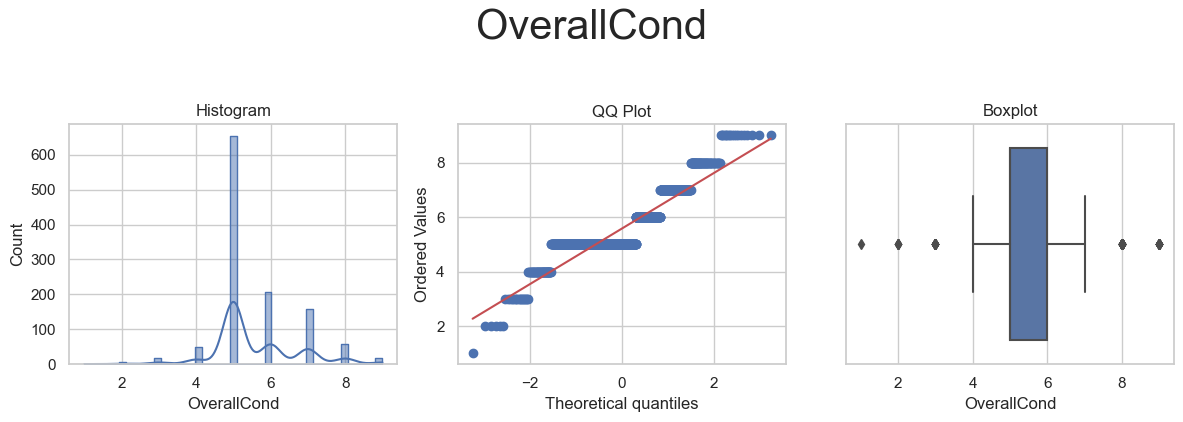

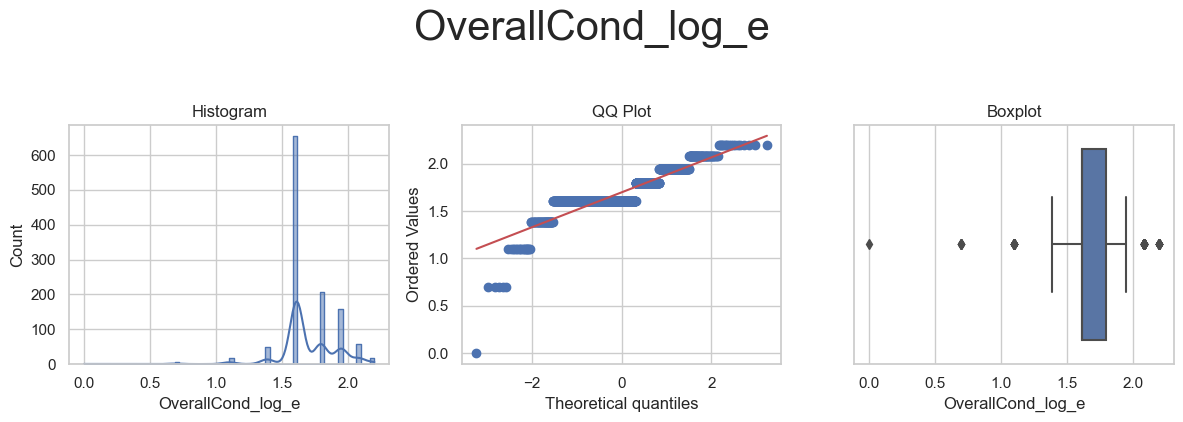

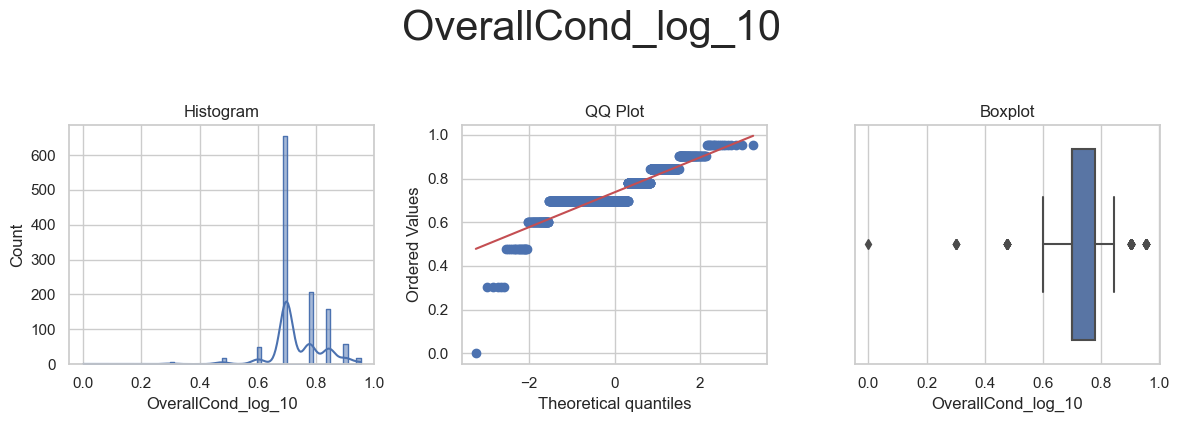

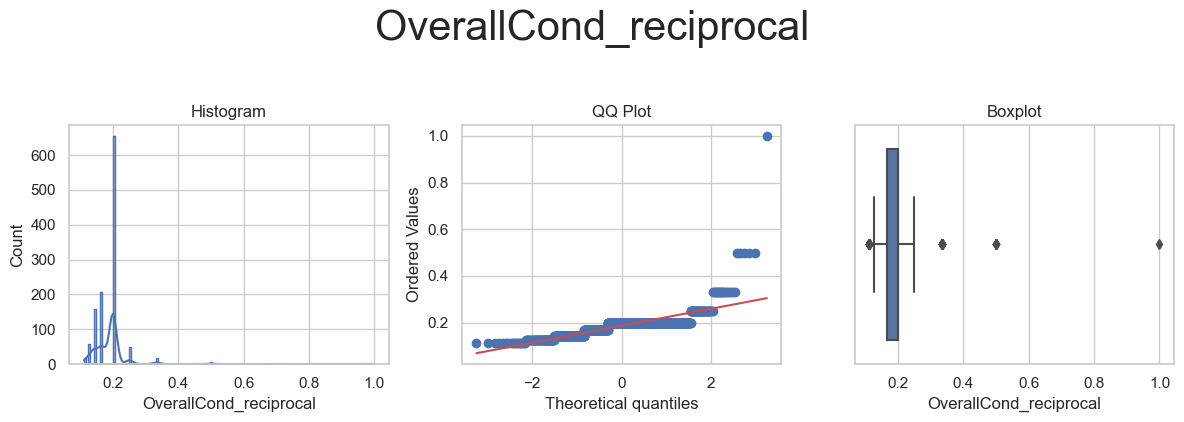

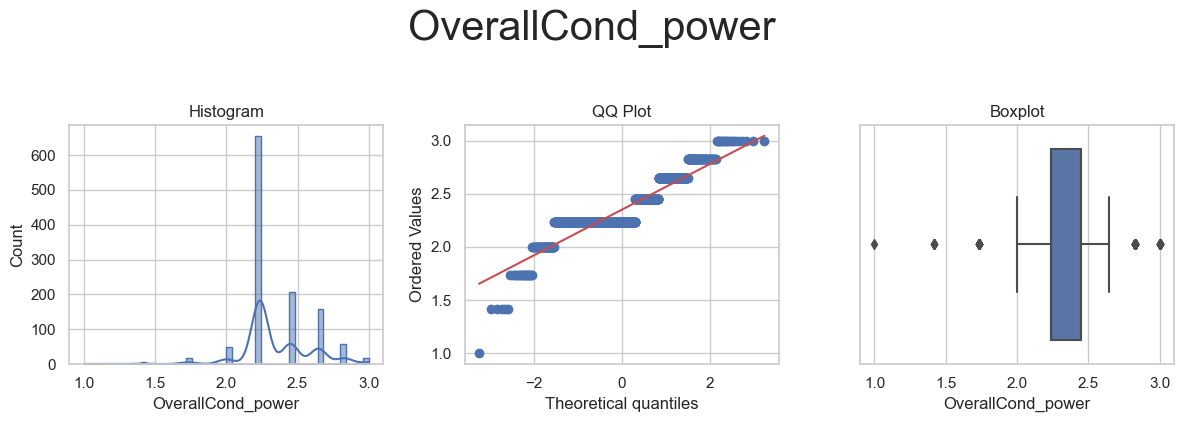

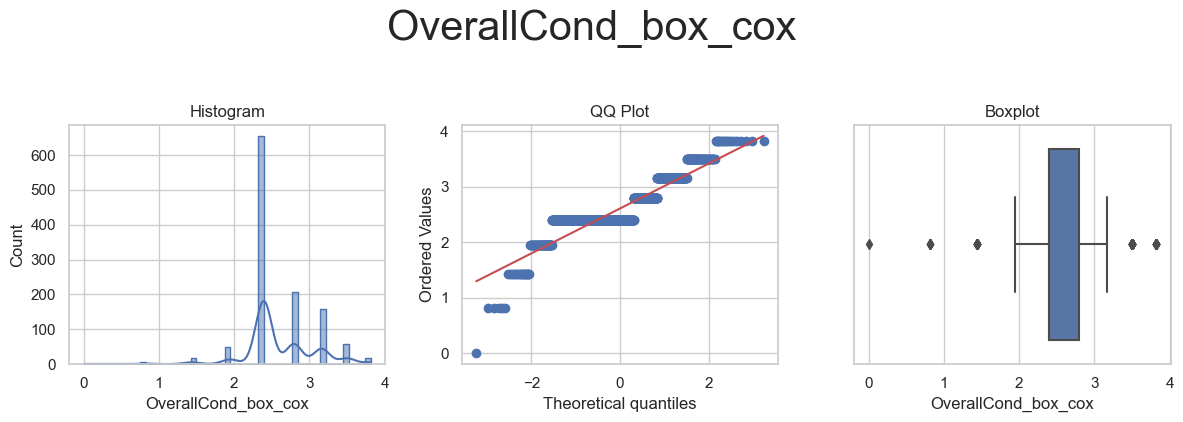

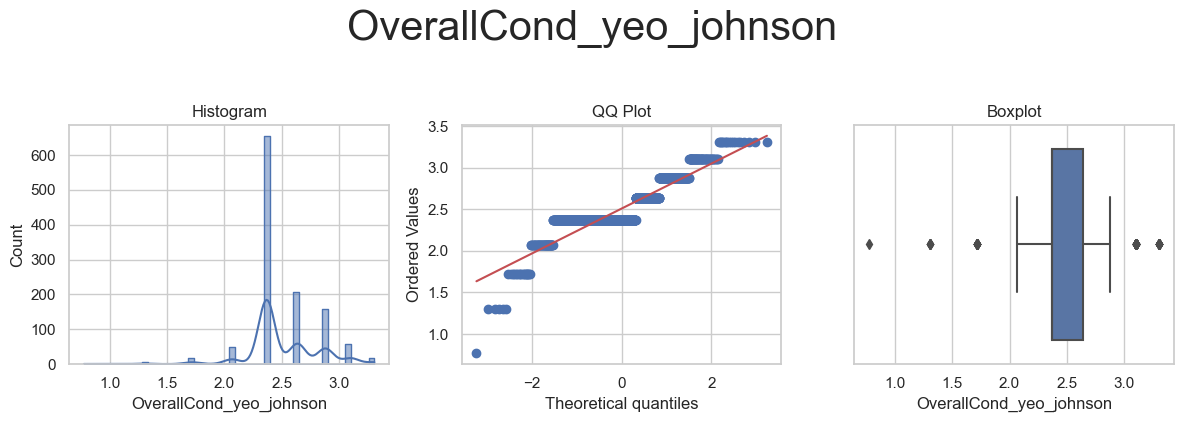



* Variable Analyzed: OverallQual
* Applied transformation: ['OverallQual_log_e', 'OverallQual_log_10', 'OverallQual_reciprocal', 'OverallQual_power', 'OverallQual_box_cox', 'OverallQual_yeo_johnson'] 



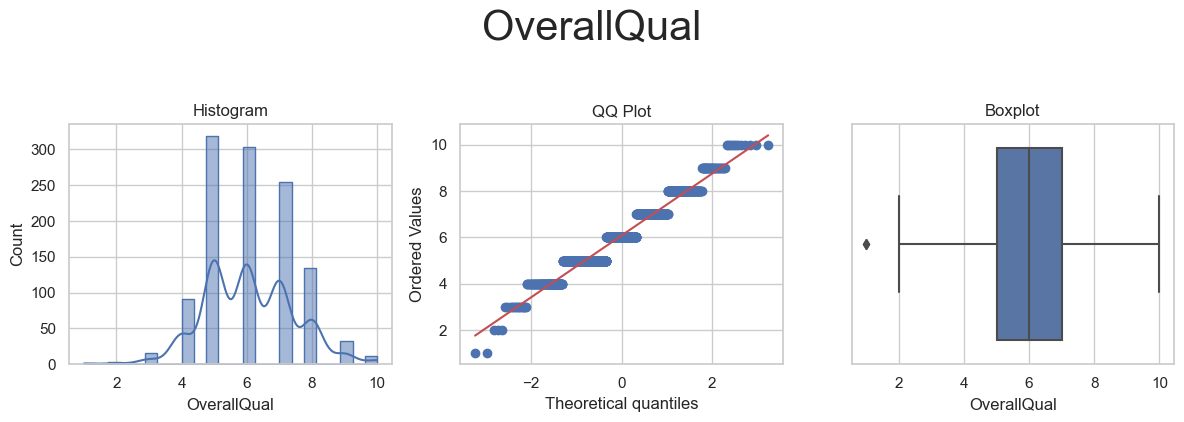

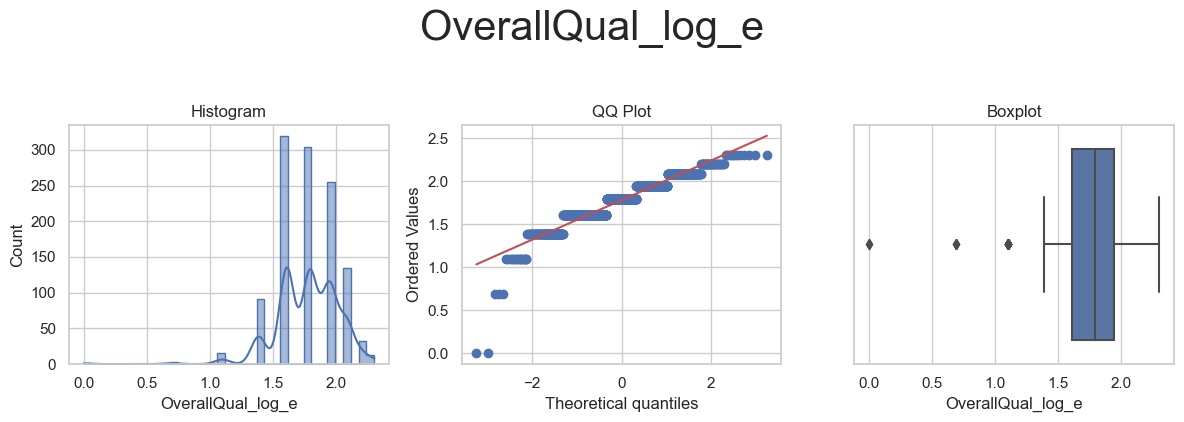

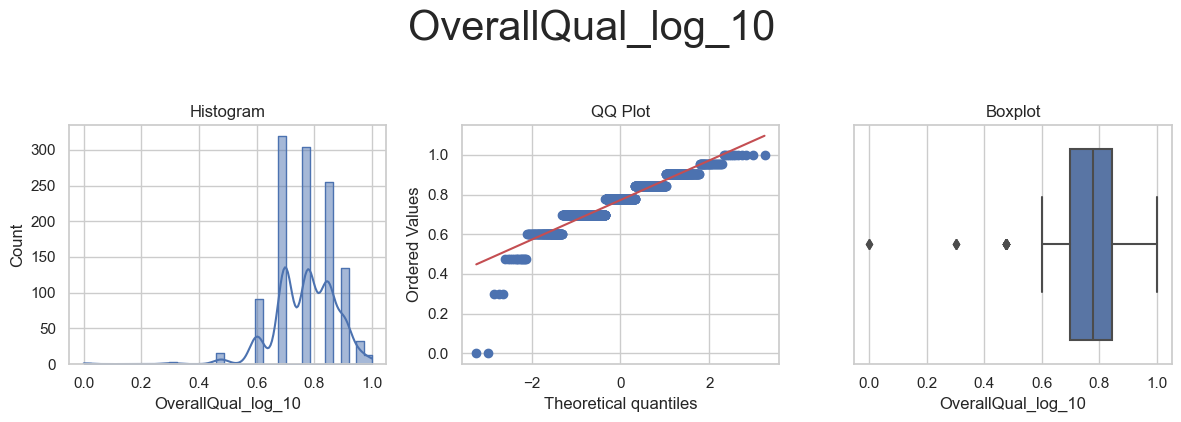

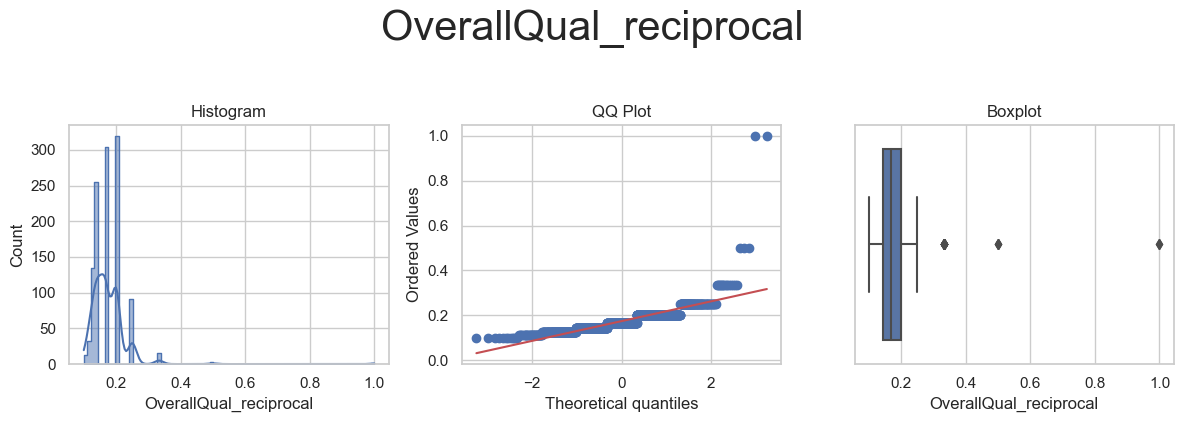

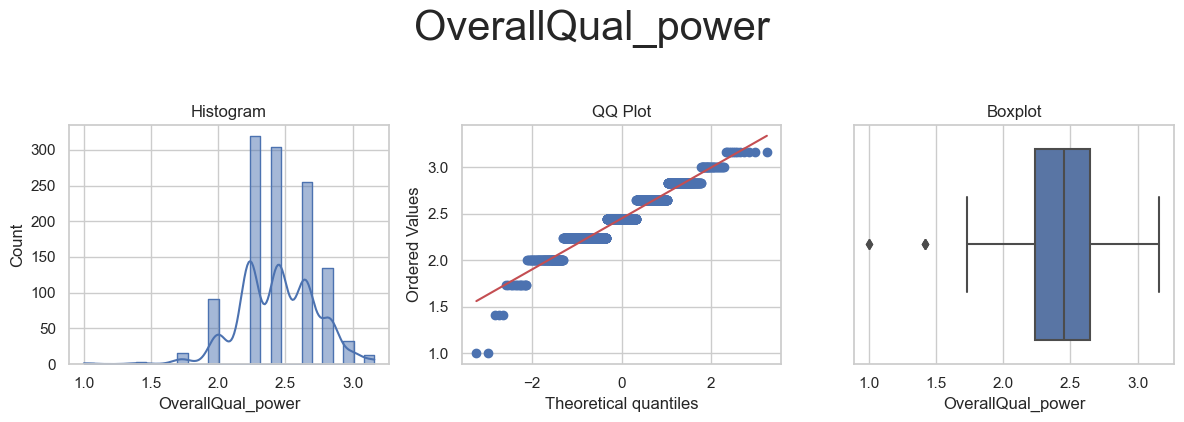

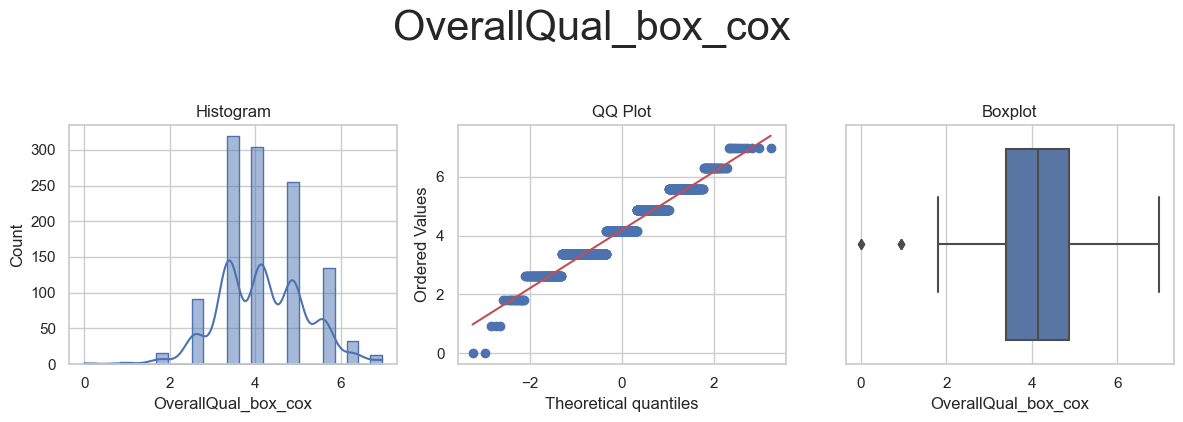

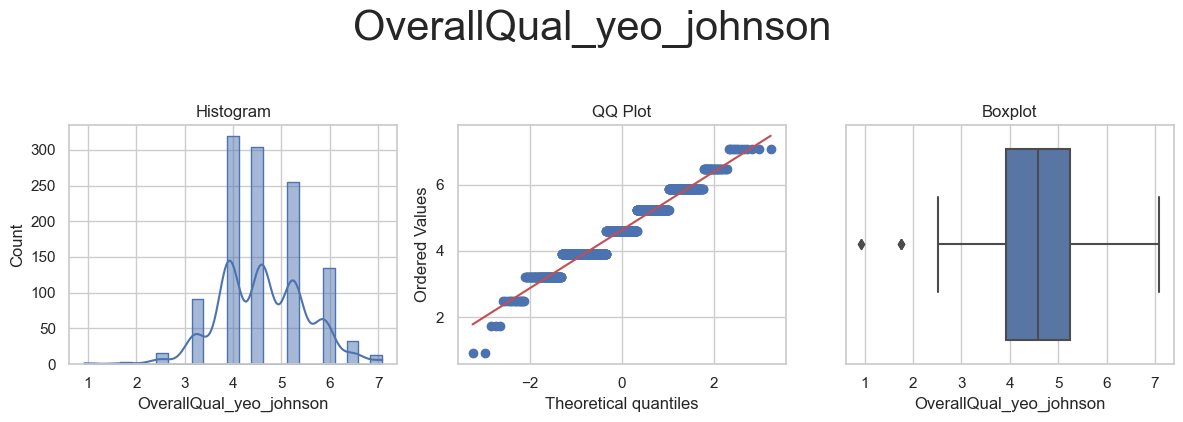



* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_power', 'TotalBsmtSF_yeo_johnson'] 



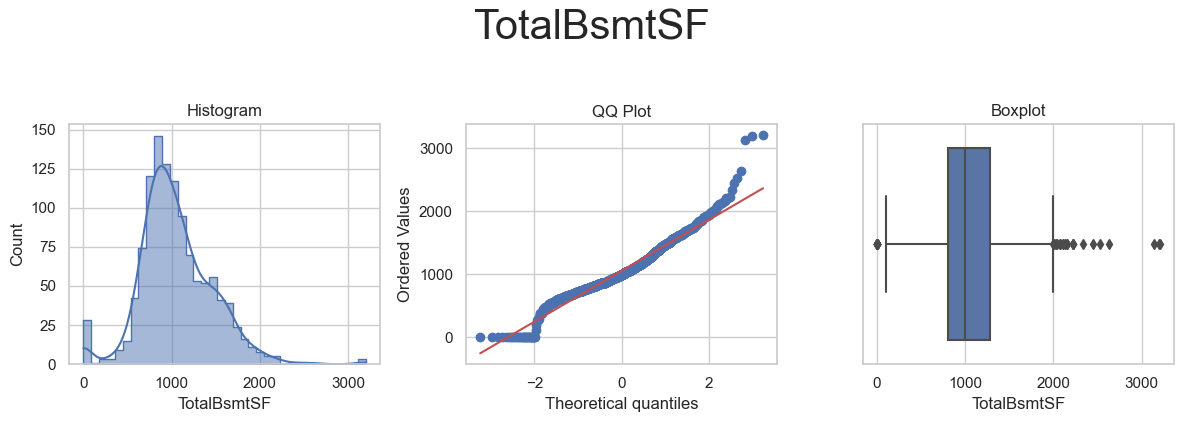

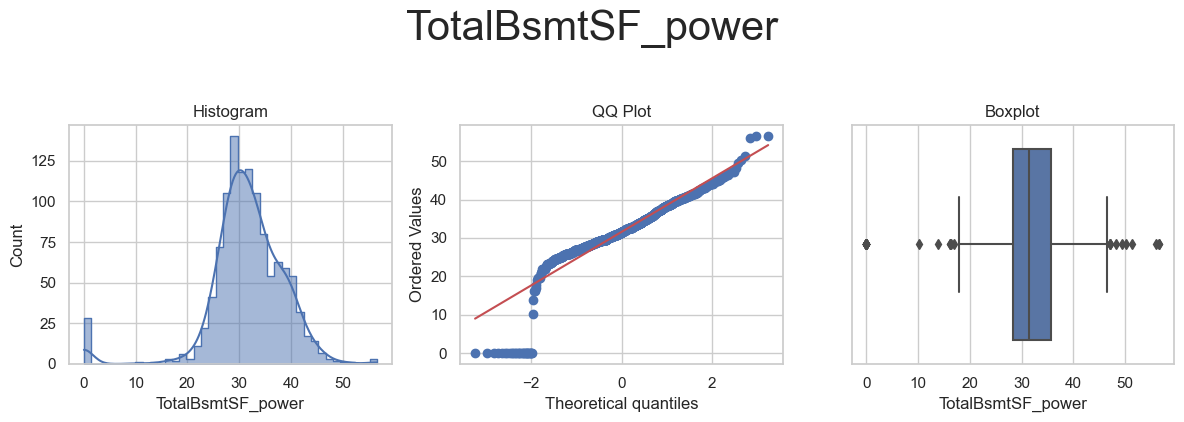

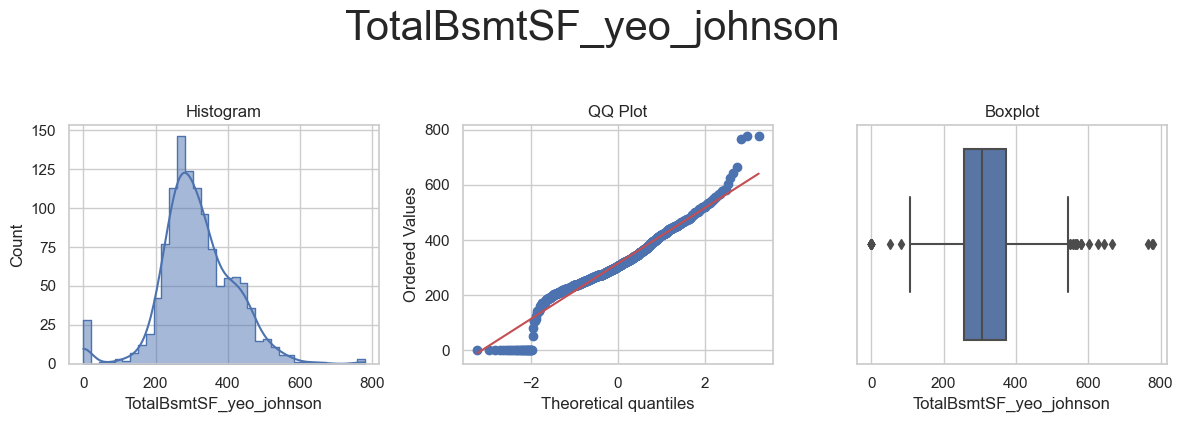



* Variable Analyzed: YearBuilt
* Applied transformation: ['YearBuilt_log_e', 'YearBuilt_log_10', 'YearBuilt_reciprocal', 'YearBuilt_power', 'YearBuilt_box_cox', 'YearBuilt_yeo_johnson'] 



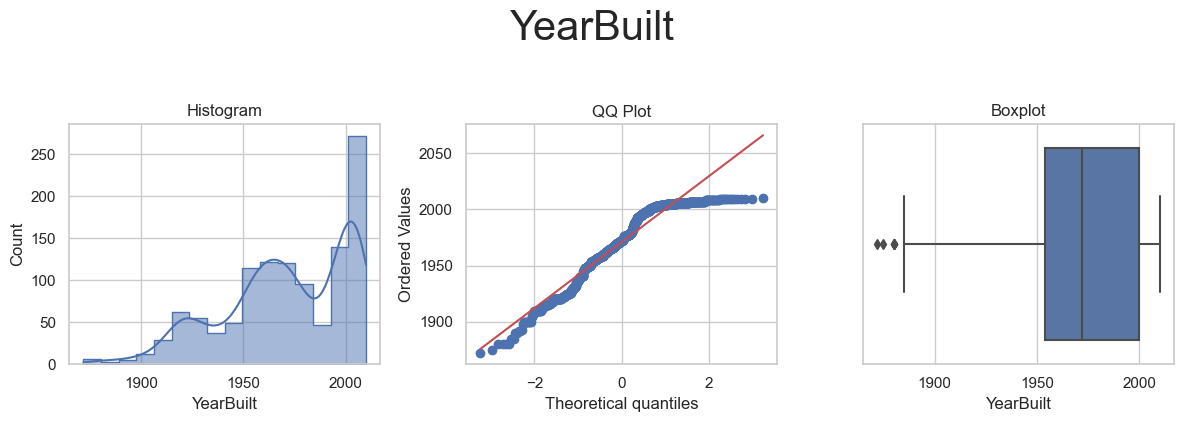

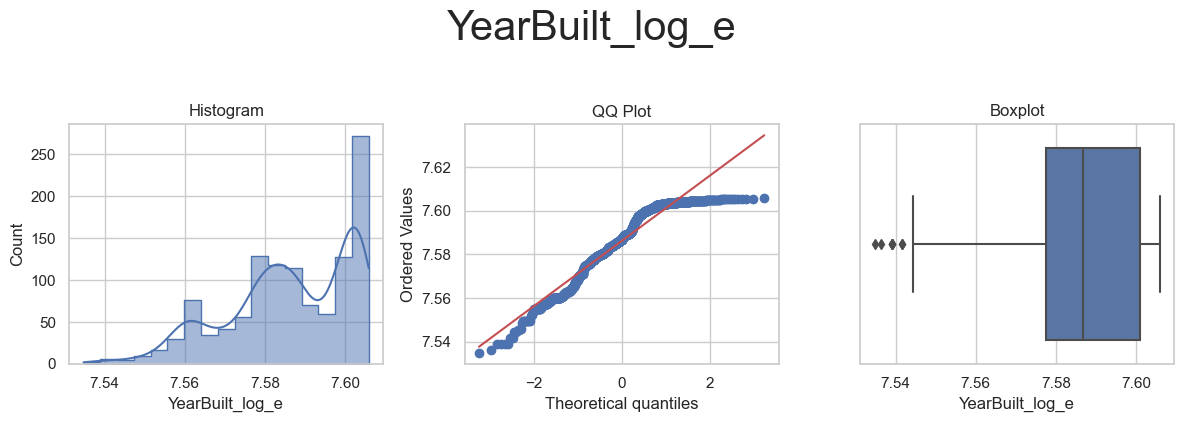

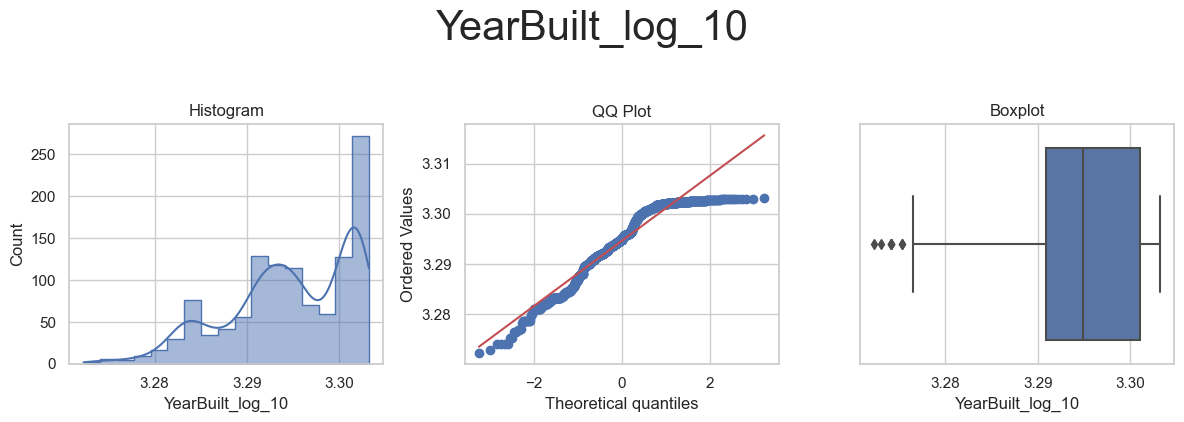

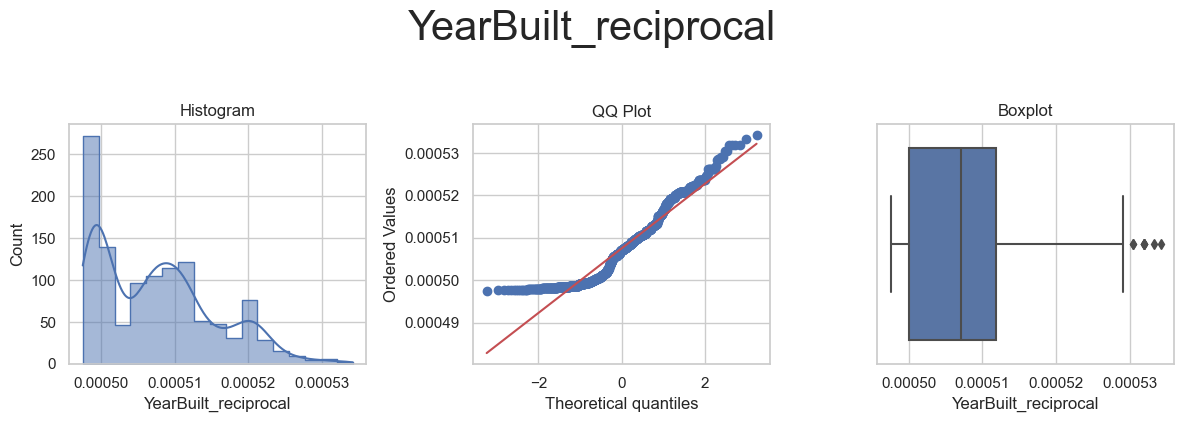

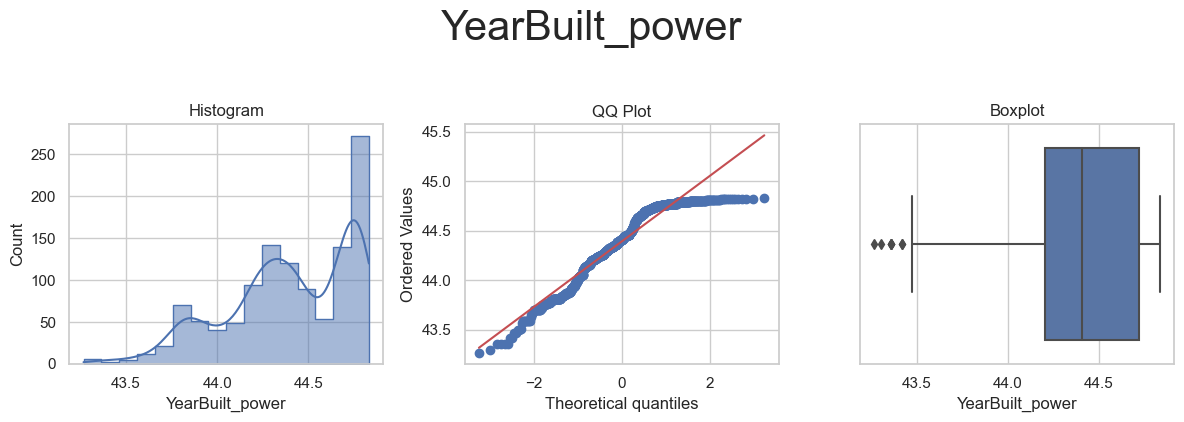

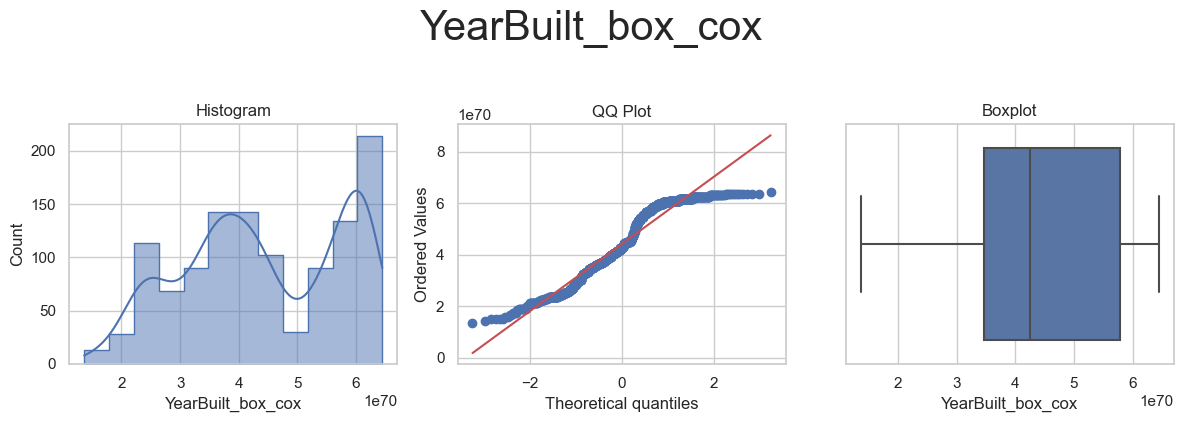

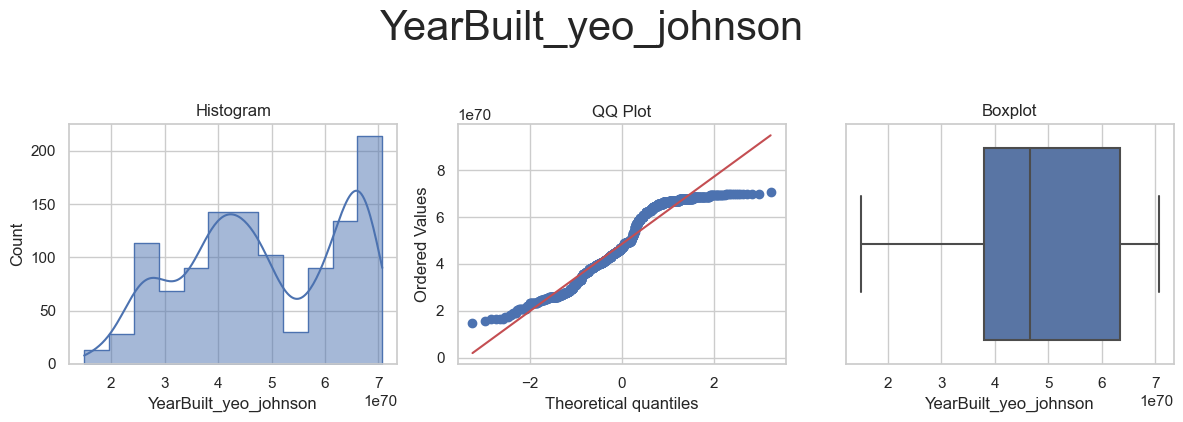



* Variable Analyzed: YearRemodAdd
* Applied transformation: ['YearRemodAdd_log_e', 'YearRemodAdd_log_10', 'YearRemodAdd_reciprocal', 'YearRemodAdd_power', 'YearRemodAdd_box_cox', 'YearRemodAdd_yeo_johnson'] 



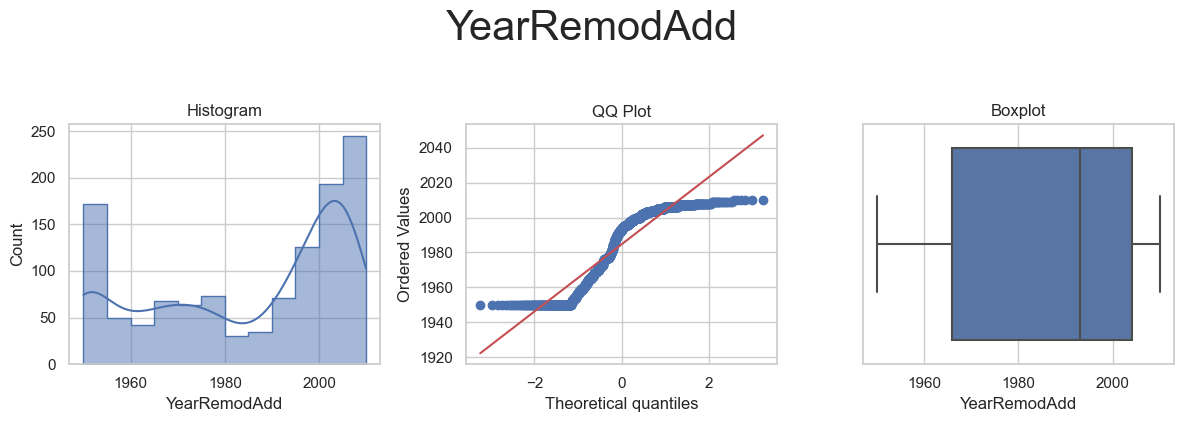

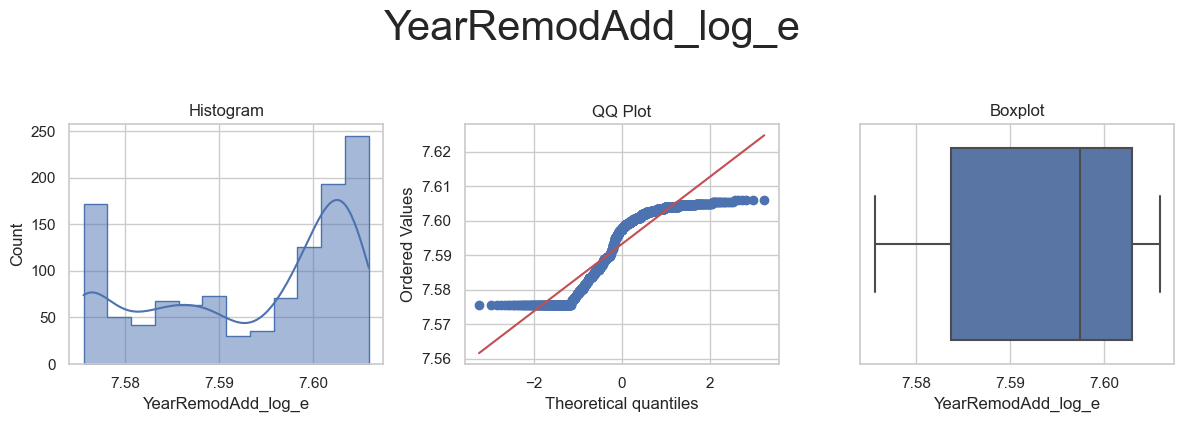

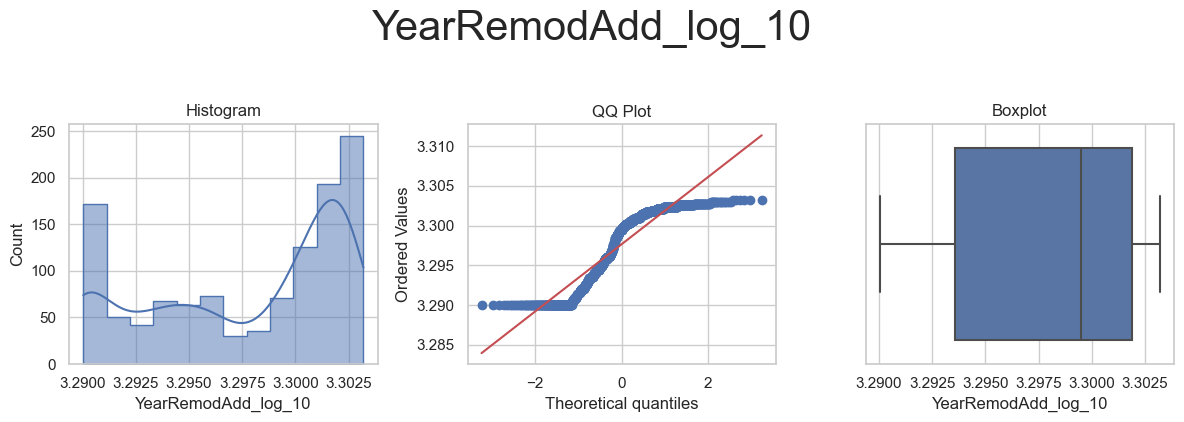

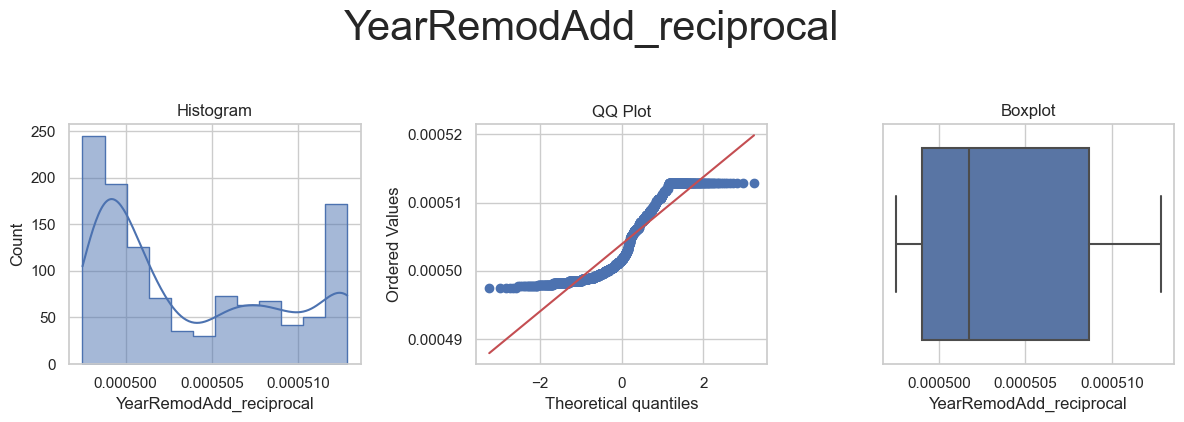

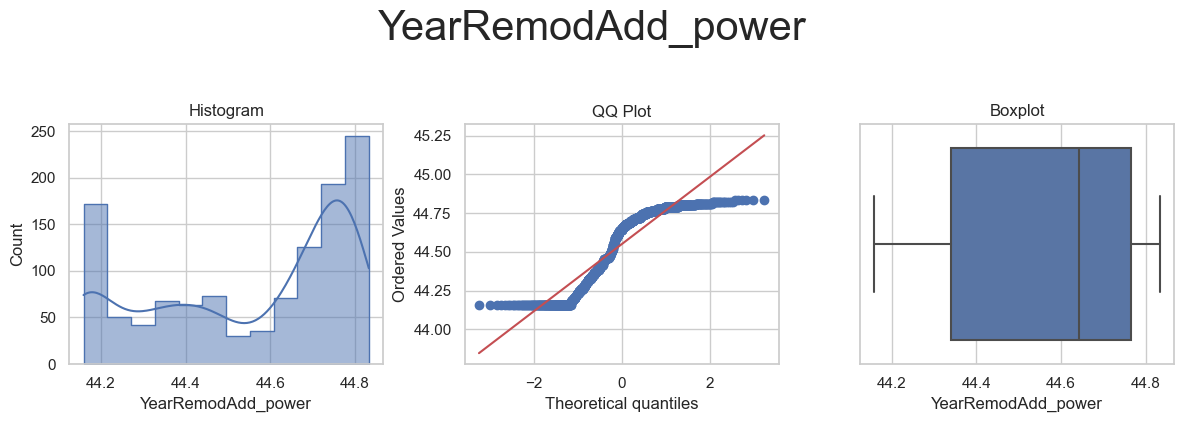

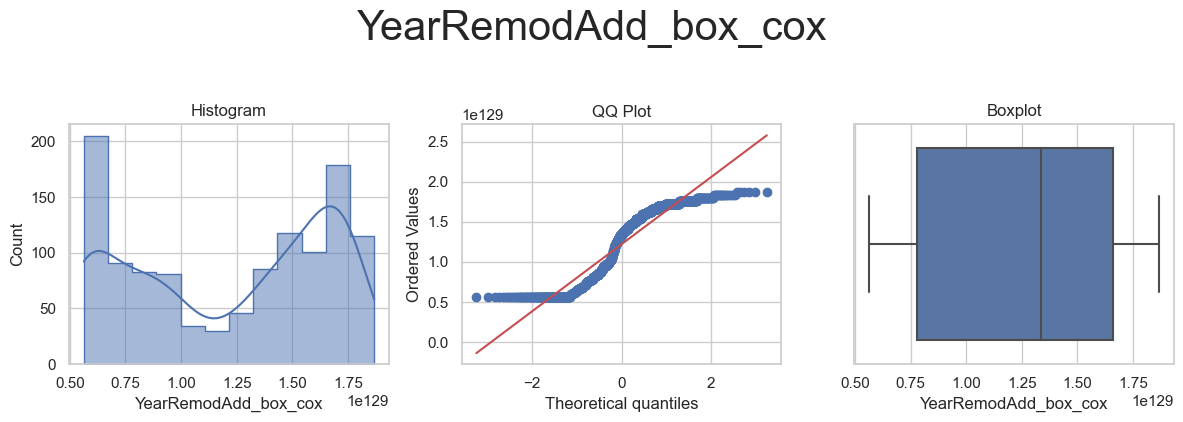

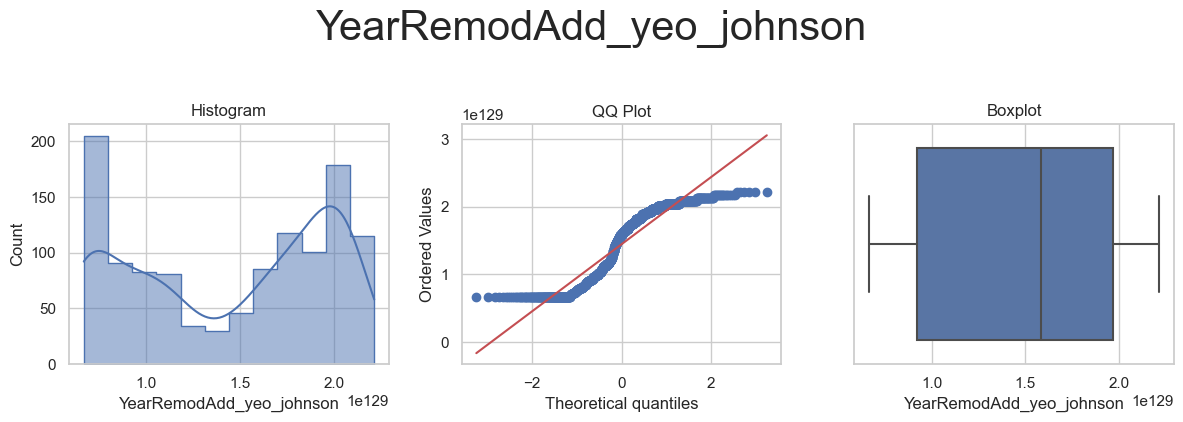

In [22]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

# Observations


For a large number of the features, there was no improvement from any of the transformations tested. The following features showed some improvement:

- 1stFlrSF - log-e/log-e10/box_cox/yeo_johnson
- BsmtUnfSF - yeo_johnson
- GarageArea - yeo_johnson
- GrLivArea - log-e/log-e10/box_cox/yeo_johnson

* Step 4 - Apply the selected transformation to the Train and Test set

### Train Set

In [34]:
from sklearn.preprocessing import PowerTransformer

# Load the dataset from the CSV file
train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0    1828.0       0.0           3.0           Av        48.0           4.0   
1     894.0       0.0           2.0           No         0.0           1.0   
2     964.0       0.0           2.0           No       713.0           5.0   

   BsmtUnfSF  GarageArea  GarageFinish  GarageYrBlt  ...  LotArea LotFrontage  \
0     1774.0       774.0           1.0       2007.0  ...  11694.0        90.0   
1      894.0       308.0           2.0       1962.0  ...   6600.0        60.0   
2      163.0       432.0           1.0       1921.0  ...  13360.0        80.0   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0       452.0        108.0          5.0          9.0       1822.0       2007   
1         0.0          0.0          5.0          5.0        894.0       1962   
2         0.0          0.0          7.0          5.0        876.0       1921   

   YearRemodAdd  SalePrice  
0          2007   314813.0  
1          1962   109500.0  
2          2006   163500.0  

[3 rows x 22 columns]

In [35]:
import os
try:
  os.makedirs(name='outputs/datasets/transformed')
except Exception as e:
  print(e)

In [36]:
# Define the list of features to be transformed
features = ['1stFlrSF', 'BsmtUnfSF', 'GarageArea', 'GrLivArea']

# Initialize the Yeo-Johnson transformer
yeo_johnson = PowerTransformer(method='yeo-johnson')

# Apply Yeo-Johnson transformation to each feature
for feature in features:
    feature_data = TrainSet[feature].values.reshape(-1, 1)
    yeo_johnson.fit(feature_data)
    transformed_data = yeo_johnson.transform(feature_data)
    TrainSet[f'{feature}_transformed'] = transformed_data

TrainSet.to_csv("outputs/datasets/transformed/TrainSetTransformed.csv", index=False)

In [37]:
TrainSet.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0    1828.0       0.0           3.0           Av        48.0           4.0   
1     894.0       0.0           2.0           No         0.0           1.0   
2     964.0       0.0           2.0           No       713.0           5.0   

   BsmtUnfSF  GarageArea  GarageFinish  GarageYrBlt  ...  OverallCond  \
0     1774.0       774.0           1.0       2007.0  ...          5.0   
1      894.0       308.0           2.0       1962.0  ...          5.0   
2      163.0       432.0           1.0       1921.0  ...          7.0   

  OverallQual  TotalBsmtSF  YearBuilt  YearRemodAdd  SalePrice  \
0         9.0       1822.0       2007          2007   314813.0   
1         5.0        894.0       1962          1962   109500.0   
2         5.0        876.0       1921          2006   163500.0   

   1stFlrSF_transformed  BsmtUnfSF_transformed  GarageArea_transformed  \
0              1.603059               1.980479                1.362951   
1             -0.675168               0.818702               -0.738276   
2             -0.435322              -0.850913               -0.143357   

   GrLivArea_transformed  
0               0.719205  
1              -1.425453  
2              -1.204075  

[3 rows x 26 columns]

### Test Set

In [38]:
# Load the dataset from the CSV file
test_set_path = "outputs/datasets/cleaned/TestSetCleaned.csv"
TestSet = pd.read_csv(test_set_path)
TestSet.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0    2515.0       0.0           4.0           No      1219.0           3.0   
1     958.0     620.0           3.0           No       403.0           4.0   
2     979.0     224.0           3.0           No       185.0           2.0   

   BsmtUnfSF  GarageArea  GarageFinish  GarageYrBlt  ...  LotArea LotFrontage  \
0      816.0       484.0           2.0       1975.0  ...  32668.0        70.0   
1      238.0       240.0           1.0       1941.0  ...   9490.0        79.0   
2      524.0       352.0           1.0       1950.0  ...   7015.0        70.0   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0         0.0          0.0          3.0          6.0       2035.0       1957   
1         0.0          0.0          7.0          6.0        806.0       1941   
2       161.0          0.0          4.0          5.0        709.0       1950   

   YearRemodAdd  SalePrice  
0          1975   200624.0  
1          1950   133000.0  
2          1950   110000.0  

[3 rows x 22 columns]

In [39]:
# Define the list of features to be transformed
features = ['1stFlrSF', 'BsmtUnfSF', 'GarageArea', 'GrLivArea']

# Initialize the Yeo-Johnson transformer
yeo_johnson = PowerTransformer(method='yeo-johnson')

# Apply Yeo-Johnson transformation to each feature
for feature in features:
    feature_data = TestSet[feature].values.reshape(-1, 1)
    yeo_johnson.fit(feature_data)
    transformed_data = yeo_johnson.transform(feature_data)
    TestSet[f'{feature}_transformed'] = transformed_data

TestSet.to_csv("outputs/datasets/transformed/TestSetTransformed.csv", index=False)

In [40]:
TestSet.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0    2515.0       0.0           4.0           No      1219.0           3.0   
1     958.0     620.0           3.0           No       403.0           4.0   
2     979.0     224.0           3.0           No       185.0           2.0   

   BsmtUnfSF  GarageArea  GarageFinish  GarageYrBlt  ...  OverallCond  \
0      816.0       484.0           2.0       1975.0  ...          3.0   
1      238.0       240.0           1.0       1941.0  ...          7.0   
2      524.0       352.0           1.0       1950.0  ...          4.0   

  OverallQual  TotalBsmtSF  YearBuilt  YearRemodAdd  SalePrice  \
0         6.0       2035.0       1957          1975   200624.0   
1         6.0        806.0       1941          1950   133000.0   
2         5.0        709.0       1950          1950   110000.0   

   1stFlrSF_transformed  BsmtUnfSF_transformed  GarageArea_transformed  \
0              2.253440               0.695093                0.128617   
1             -0.388461              -0.521989               -0.923221   
2             -0.319456               0.177947               -0.419581   

   GrLivArea_transformed  
0               1.636304  
1               0.349955  
2              -0.449590  

[3 rows x 26 columns]

---

### SmartCorrelatedSelection Variables

* Step 1: Select variable(s)

In [ ]:
# for this transformer, you don't need to select variables, since you need all variables for this transformer

* Step 2: Create a separate DataFrame, with your variable(s)

In [41]:
df_engineering = TrainSet.copy()
df_engineering.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0    1828.0       0.0           3.0           Av        48.0           4.0   
1     894.0       0.0           2.0           No         0.0           1.0   
2     964.0       0.0           2.0           No       713.0           5.0   

   BsmtUnfSF  GarageArea  GarageFinish  GarageYrBlt  ...  OverallCond  \
0     1774.0       774.0           1.0       2007.0  ...          5.0   
1      894.0       308.0           2.0       1962.0  ...          5.0   
2      163.0       432.0           1.0       1921.0  ...          7.0   

  OverallQual  TotalBsmtSF  YearBuilt  YearRemodAdd  SalePrice  \
0         9.0       1822.0       2007          2007   314813.0   
1         5.0        894.0       1962          1962   109500.0   
2         5.0        876.0       1921          2006   163500.0   

   1stFlrSF_transformed  BsmtUnfSF_transformed  GarageArea_transformed  \
0              1.603059               1.980479                1.362951   
1             -0.675168               0.818702               -0.738276   
2             -0.435322              -0.850913               -0.143357   

   GrLivArea_transformed  
0               0.719205  
1              -1.425453  
2              -1.204075  

[3 rows x 26 columns]

* Step 3: Create engineered variables(s) applying the transformation(s)

In [42]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_engineering)
corr_sel.correlated_feature_sets_

[{'1stFlrSF', '1stFlrSF_transformed', 'TotalBsmtSF'},
 {'2ndFlrSF', 'GrLivArea', 'GrLivArea_transformed'},
 {'BsmtFinSF1', 'BsmtFinType1'},
 {'BsmtUnfSF', 'BsmtUnfSF_transformed'},
 {'GarageArea', 'GarageArea_transformed', 'SalePrice'},
 {'GarageYrBlt', 'YearBuilt', 'YearRemodAdd'}]

In [43]:
corr_sel.features_to_drop_

['1stFlrSF',
 '2ndFlrSF',
 'BsmtFinType1',
 'GarageArea',
 'GarageYrBlt',
 'YearRemodAdd',
 '1stFlrSF_transformed',
 'BsmtUnfSF_transformed',
 'GarageArea_transformed',
 'GrLivArea_transformed']

---

# So what is the conclusion? :)


The list below shows the transformations needed for feature engineering.
  * You will add these steps to the ML Pipeline

# Transformation To Consider
Feature Engineering Transformers 
  * Ordinal categorical encoding: `['BsmtExposure', 'KitchenQual']`
  * Numerical Transformation - YeoJohnson `['1stFlrSF', 'BsmtUnfSF', 'GarageArea', 'GrLivArea']`
  * Smart Correlation Selection: `['1stFlrSF', '2ndFlrSF', 'BsmtFinType1', 'GarageArea', 'GarageYrBlt', 'YearRemodAdd', '1stFlrSF_transformed',
'BsmtUnfSF_transformed', 'GarageArea_transformed', 'GrLivArea_transformed']`
  

---